# Initial Prepearation

## Import

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import geopandas as gpd
from pathlib import Path
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import chi2_contingency
from google.colab import drive
from collections import Counter,defaultdict
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Markdown, display
sns.set(style="whitegrid", context="notebook")
from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.express as px
!pip install dash==2.14.2 dash-bootstrap-components==1.6.0
from dash import Dash, html, dcc, Output, Input
import dash_bootstrap_components as dbc
# Make plots a bit larger by default
plt.rcParams["figure.figsize"] = (8, 5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading CSV file and output Saving Path

In [134]:
file_path = "/content/drive/MyDrive/Pet Project/Montgomery County/Crime_Dataset_Coursework1-1.xlsx"
df = pd.read_excel(file_path)
df

,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201202980,3550,180042096,08/23/2018 09:52:08 PM,35B,1,Crime Against Society,Drug Equipment Violations,DRUGS - NARCOTIC EQUIP - POSSESS,GERMANTOWN,...,NaN,MIDDLEBROOK,NaN,RD,08/23/2018 09:52:00 PM,NaN,39.177744,-77.265619,5D,"(39.1777, -77.2656)"
1,201181293,3522,180015424,03/30/2018 01:00:55 AM,35A,1,Crime Against Society,Drug/Narcotic Violations,DRUGS - OPIUM OR DERIVATIVE - POSSESS,BETHESDA,...,NaN,WOODMONT,NaN,AVE,03/30/2018 01:01:00 AM,NaN,38.992693,-77.097063,2D,"(38.9927, -77.0971)"
2,201181293,3562,180015424,03/30/2018 01:00:55 AM,35A,1,Crime Against Society,Drug/Narcotic Violations,DRUGS - MARIJUANA - POSSESS,BETHESDA,...,NaN,WOODMONT,NaN,AVE,03/30/2018 01:01:00 AM,NaN,38.992693,-77.097063,2D,"(38.9927, -77.0971)"
3,201193163,3520,180029476,06/14/2018 10:26:45 PM,35A,1,Crime Against Society,Drug/Narcotic Violations,DRUGS - OPIUM OR DERIVATIVE - SELL,MONTGOMERY VILLAGE,...,NaN,QUINCE ORCHARD,NaN,RD,06/14/2018 10:26:00 PM,06/15/2018 03:00:00 AM,39.147954,-77.218189,6D,"(39.148, -77.2182)"
4,201204355,2204,180043926,09/03/2018 12:06:54 PM,220,1,Crime Against Property,Burglary/Breaking and Entering,BURGLARY - NO FORCED ENTRY-RESIDENTIAL,BETHESDA,...,NaN,FALSTONE,NaN,AVE,09/02/2018 11:30:00 PM,09/03/2018 12:30:00 AM,38.966174,-77.096561,2D,"(38.9662, -77.0966)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306089,201320571,1399,210006666,02/21/2021 07:25:28 AM,13B,1,Crime Against Person,Simple Assault,ASSAULT - 2ND DEGREE,MONTGOMERY VILLAGE,...,NaN,TRANSHIRE,NaN,RD,02/20/2021 08:00:00 PM,NaN,39.172701,-77.197340,6D,"(39.1727, -77.1973)"
306090,201329875,2305,210017101,05/06/2021 10:54:47 PM,23F,1,Crime Against Property,Theft From Motor Vehicle,LARCENY - FROM AUTO,WHEATON,...,NaN,ATHERTON,NaN,DR,05/06/2021 03:15:00 AM,NaN,39.059672,-77.075995,4D,"(39.0597, -77.076)"
306091,201329751,5016,210016952,05/05/2021 10:38:58 PM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,BALTUSROL,NaN,DR,05/05/2021 10:38:00 PM,NaN,39.199722,-77.273039,5D,"(39.1997, -77.273)"
306092,201323117,9099,210009468,03/13/2021 12:07:14 PM,90Z,1,Crime Against Society,All Other Offenses,ALL OTHER OFFENSES,SILVER SPRING,...,NaN,FENTON,NaN,ST,03/13/2021 01:35:00 PM,NaN,38.985813,-77.022915,3D,"(38.9858, -77.0229)"


## Missing Value Checking

In [135]:
# check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# report building
missing_report = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage (%)": (missing_values / len(df) * 100).round(2)
})

# display report
missing_report

,Missing Values,Percentage (%)
Street Suffix,300662,98.23
Street Prefix,292463,95.55
End_Date_Time,161658,52.81
Dispatch Date / Time,49029,16.02
Block Address,26206,8.56
Address Number,26109,8.53
Zip Code,3179,1.04
Beat,1532,0.50
Sector,1530,0.50
City,1276,0.42


## Cleaning

In [136]:
# Helpers
def norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", str(s).lower())

def pick(colmap, *candidates):
    for cand in candidates:
        key = norm(cand)
        if key in colmap:
            return colmap[key]
    return None

def build_colmap(df):
    return {norm(c): c for c in df.columns}

# per-type IQR capping helper (upper outliers -> NaN)
def iqr_cap_series(s):
    s = pd.to_numeric(s, errors="coerce")
    valid = s.dropna()
    if valid.empty:
        return s
    q1, q3 = np.nanpercentile(valid, [25, 75])
    iqr = q3 - q1
    upper = q3 + 3 * iqr
    return s.where((s <= upper) | s.isna(), np.nan)

# County bounds (approx)
LAT_MIN, LAT_MAX = 38.85, 39.45
LON_MIN, LON_MAX = -77.55, -76.75

# Single pass column-wise cleaning (df_clean)
def clean_all(df):
    colmap = build_colmap(df)

    # 1) Column picks (originals)
    c_inc   = pick(colmap, "Incident ID", "IncidentID", "CR Number", "CRNumber", "Case Number")
    c_sdt   = pick(colmap, "Start_Date_Time", "Start Date Time", "Start Date/Time", "Start Time", "StartDateTime")
    c_edt   = pick(colmap, "End_Date_Time", "End Date Time", "End Date/Time", "End Time", "EndDateTime")
    c_ddt   = pick(colmap, "Dispatch Date / Time", "Dispatch Date Time", "Dispatch", "DispatchDateTime", "DispatchDate/Time")
    c_cn1   = pick(colmap, "Crime Name1", "CrimeName1", "Primary Crime", "Crime Category", "Crime Type")
    c_cn2   = pick(colmap, "Crime Name2", "CrimeName2")
    c_cn3   = pick(colmap, "Crime Name3", "CrimeName3")
    c_dist  = pick(colmap, "Police District Name", "Police District", "District Name", "District")
    c_city  = pick(colmap, "City")
    c_lat   = pick(colmap, "Latitude", "Lat")
    c_lon   = pick(colmap, "Longitude", "Lon", "Long")
    c_vic   = pick(colmap, "Victims", "Victims ", "Victim Count", "Num Victims")
    c_off   = pick(colmap, "Offence Code", "Offense Code", "OffenceCode", "OffenseCode")
    # Bebe
    c_crn   = pick(colmap, "CR Number", "CRNumber")
    c_nib   = pick(colmap, "NIBRS Code", "NIBRSCode")
    c_place = pick(colmap, "Place")
    # NEW: Agency
    c_agency = pick(colmap, "Agency", "Agency Code")

    keep_cols = [c for c in [c_inc, c_sdt, c_edt, c_ddt, c_cn1, c_cn2, c_cn3,
                             c_dist, c_city, c_lat, c_lon, c_vic, c_off] if c]
    # Bebe
    keep_cols += [c for c in [c_crn, c_nib, c_place] if c]
    # NEW: keep Agency
    if c_agency:
        keep_cols.append(c_agency)

    # 3) NEW: keep Address / Street / Location fields like notebook
    addr_cols = [
        c for c in df.columns
        if isinstance(c, str) and any(key in c for key in ["Address", "Street", "Location"])
    ]

    addr_cols = [
    c for c in addr_cols
    if c not in ["Street Prefix", "Street Suffix"]
    ]
    keep_cols += [c for c in addr_cols if c not in keep_cols]

    tmp = df[keep_cols].copy()

    # 2) Standardize column names (new clean fields)
    rename_map = {}
    if c_inc: rename_map[c_inc] = "incident_id"
    if c_sdt: rename_map[c_sdt] = "start_dt"
    if c_edt: rename_map[c_edt] = "end_dt"
    if c_ddt: rename_map[c_ddt] = "dispatch_dt"
    if c_cn1: rename_map[c_cn1] = "crime_name1"
    if c_cn2: rename_map[c_cn2] = "crime_name2"
    if c_cn3: rename_map[c_cn3] = "crime_name3"
    if c_dist: rename_map[c_dist] = "district_raw"
    if c_city: rename_map[c_city] = "city_raw"
    if c_lat: rename_map[c_lat] = "lat"
    if c_lon: rename_map[c_lon] = "lon"
    if c_vic: rename_map[c_vic] = "victims"
    if c_off: rename_map[c_off] = "offence_code"
    # Bebe NEW: standard names for CR Number, NIBRS Code, Place
    if c_crn:   rename_map[c_crn]   = "cr_number"
    if c_nib:   rename_map[c_nib]   = "nibrs_code"
    if c_place: rename_map[c_place] = "place"
    # NEW: Agency
    if c_agency: rename_map[c_agency] = "agency"

    tmp = tmp.rename(columns=rename_map)

    # NEW: clean agency codes
    if "agency" in tmp.columns:
        tmp["agency"] = (
            tmp["agency"]
            .astype(str)
            .str.strip()
            .replace({"nan": np.nan, "": np.nan})
        )
        tmp["agency"] = tmp["agency"].str.upper()   # GPD, MCPD, etc.

    # 3) Crime names: strip; drop rows where all three are empty
    for c in ["crime_name1", "crime_name2", "crime_name3"]:
        if c in tmp.columns:
            tmp[c] = tmp[c].astype(str).str.strip().replace({"nan": ""})
    cn_cols = [c for c in ["crime_name1", "crime_name2", "crime_name3"] if c in tmp.columns]
    if cn_cols:
        keep_mask = ~tmp[cn_cols].apply(lambda r: all((x == "" or pd.isna(x)) for x in r), axis=1)
        tmp = tmp.loc[keep_mask].copy()
    # define crime_type as primary label
    if "crime_name1" in tmp.columns:
        tmp["crime_type"] = tmp["crime_name1"].replace({"": np.nan})
    else:
        tmp["crime_type"] = np.nan

    # Bebe
    # 3b) NEW: Clean NIBRS Code, Place, CR Number, Offence Code (from Cell 2 logic)
    # NIBRS Code -> string for consistent handling
    if "nibrs_code" in tmp.columns:
        tmp["nibrs_code"] = tmp["nibrs_code"].astype(str).str.strip().replace({"nan": np.nan})

    # Place -> fill missing with 'Unknown'
    if "place" in tmp.columns:
        tmp["place"] = tmp["place"].astype(str).str.strip().replace({"nan": np.nan})
        tmp["place"] = tmp["place"].fillna("Unknown")
        tmp.loc[tmp["place"].eq(""), "place"] = "Unknown"

    # CR Number -> keep a clean numeric version if present
    if "cr_number" in tmp.columns:
        tmp["cr_number"] = pd.to_numeric(tmp["cr_number"], errors="coerce")

    # Offence Code -> numeric per Cell 2 note
    if "offence_code" in tmp.columns:
        tmp["offence_code"] = pd.to_numeric(tmp["offence_code"], errors="coerce")
    # Bebe End

    # 3c) City imputation like notebook (fill by district mode)
    if "city_raw" in tmp.columns and "district_raw" in tmp.columns:
        city_s = tmp["city_raw"].astype(str).str.strip().replace({"nan": np.nan})
        dist_s = tmp["district_raw"].astype(str)

        def _fill_mode(g):
            mode = g.mode(dropna=True)
            return g.fillna(mode.iloc[0]) if not mode.empty else g

        tmp["city_raw"] = city_s.groupby(dist_s).transform(_fill_mode)

    # 4) District fill
    tmp["district"] = np.nan
    if "district_raw" in tmp.columns:
        tmp["district"] = tmp["district_raw"].astype(str)
    tmp["district"] = tmp["district"].astype(str).str.strip().replace({"nan": ""})
    if "city_raw" in tmp.columns:
        city_s = tmp["city_raw"].astype(str).str.strip().replace({"nan": ""})
        dist_empty = tmp["district"].eq("") | tmp["district"].isna()
        city_has   = city_s.ne("") & city_s.notna()
        tmp.loc[dist_empty & city_has, "district"] = city_s[dist_empty & city_has]
    tmp["district"] = tmp["district"].where(tmp["district"].ne(""), np.nan)

    # 5) Time columns: parse; do not drop missing
    for c in ["start_dt", "end_dt", "dispatch_dt"]:
        if c in tmp.columns:
            tmp[c] = pd.to_datetime(tmp[c], errors="coerce")

    # 5b) Notebook style fixes
    if {"start_dt", "end_dt"}.issubset(tmp.columns):
        both = tmp["start_dt"].notna() & tmp["end_dt"].notna()
        swap_mask = both & (tmp["start_dt"] > tmp["end_dt"])
        if swap_mask.any():
            tmp.loc[swap_mask, ["start_dt", "end_dt"]] = (
                tmp.loc[swap_mask, ["end_dt", "start_dt"]].to_numpy()
            )

    if {"start_dt", "end_dt", "dispatch_dt"}.issubset(tmp.columns):
        m = (
            tmp["end_dt"].isna()
            & tmp["dispatch_dt"].notna()
            & tmp["start_dt"].notna()
            & (tmp["dispatch_dt"] > tmp["start_dt"])
        )
        if m.any():
            tmp.loc[m, "end_dt"] = tmp.loc[m, "dispatch_dt"]

    # 6) Derived time metrics
    tmp["duration_hours"] = np.nan
    if {"start_dt", "end_dt"}.issubset(tmp.columns):
        m = tmp["start_dt"].notna() & tmp["end_dt"].notna()
        tmp.loc[m, "duration_hours"] = (tmp.loc[m, "end_dt"] - tmp.loc[m, "start_dt"]).dt.total_seconds() / 3600.0
        tmp.loc[tmp["duration_hours"] < 0, "duration_hours"] = np.nan

    tmp["report_delay_min"] = np.nan
    if {"start_dt", "dispatch_dt"}.issubset(tmp.columns):
        m = tmp["start_dt"].notna() & tmp["dispatch_dt"].notna()
        tmp.loc[m, "report_delay_min"] = (tmp.loc[m, "dispatch_dt"] - tmp["start_dt"]).dt.total_seconds() / 60.0
        tmp.loc[tmp["report_delay_min"] < -60, "report_delay_min"] = np.nan

    # 7) Victims numeric
    if "victims" in tmp.columns:
        tmp["victims"] = pd.to_numeric(tmp["victims"], errors="coerce")
        tmp.loc[tmp["victims"] < 0, "victims"] = np.nan

    # 8) Lat/Lon clean
    if "lat" in tmp.columns:
        tmp["lat"] = pd.to_numeric(tmp["lat"], errors="coerce")
    if "lon" in tmp.columns:
        tmp["lon"] = pd.to_numeric(tmp["lon"], errors="coerce")
    tmp["in_bounds"] = np.where(
        tmp["lat"].between(LAT_MIN, LAT_MAX) & tmp["lon"].between(LON_MIN, LON_MAX),
        True, False
    )
    oob = ~tmp["in_bounds"]
    if "lat" in tmp.columns: tmp.loc[oob, "lat"] = np.nan
    if "lon" in tmp.columns: tmp.loc[oob, "lon"] = np.nan

    # 9) Deduplicate Incident ID
    if "incident_id" in tmp.columns:
        for c in ["district", "crime_type", "offence_code", "agency"]:
            if c in tmp.columns:
                tmp[c] = tmp[c].astype(str).replace({"nan": np.nan}).where(lambda s: s.ne(""), np.nan)

        agg_map = {
            "district": "first",
            "city_raw": "first" if "city_raw" in tmp.columns else "first",
            "crime_type": "first",
            "crime_name1": "first" if "crime_name1" in tmp.columns else "first",
            "crime_name2": "first" if "crime_name2" in tmp.columns else "first",
            "crime_name3": "first" if "crime_name3" in tmp.columns else "first",
            "start_dt": "first",
            "end_dt": "first",
            "dispatch_dt": "first",
            "duration_hours": "first",
            "report_delay_min": "first",
            "victims": "max",
            "lat": "first",
            "lon": "first",
            "in_bounds": "first",
            "offence_code": "first" if "offence_code" in tmp.columns else "first",
            # Bebe: NEW: keep first values for added fields
            "nibrs_code": "first" if "nibrs_code" in tmp.columns else "first",
            "place": "first" if "place" in tmp.columns else "first",
            "cr_number": "first" if "cr_number" in tmp.columns else "first",
            # NEW: agency
            "agency": "first" if "agency" in tmp.columns else "first",
        }
        agg_map = {k: v for k, v in agg_map.items() if k in tmp.columns}
        tmp = (tmp
               .sort_values(["incident_id"])
               .groupby("incident_id", as_index=False)
               .agg(**{k: (k, v) for k, v in agg_map.items()}))

    # 10) Re-compute derived time metrics after aggregation
    if {"start_dt", "end_dt"}.issubset(tmp.columns):
        tmp["duration_hours"] = np.where(
            tmp["start_dt"].notna() & tmp["end_dt"].notna(),
            (tmp["end_dt"] - tmp["start_dt"]).dt.total_seconds() / 3600.0,
            np.nan
        )
        tmp.loc[tmp["duration_hours"] < 0, "duration_hours"] = np.nan

    if {"start_dt", "dispatch_dt"}.issubset(tmp.columns):
        tmp["report_delay_min"] = np.where(
            tmp["start_dt"].notna() & tmp["dispatch_dt"].notna(),
            (tmp["dispatch_dt"] - tmp["start_dt"]).dt.total_seconds() / 60.0,
            np.nan
        )
        tmp.loc[tmp["report_delay_min"] < -60, "report_delay_min"] = np.nan

    # 11) Optional: per-crime-type IQR capping
    if "crime_type" in tmp.columns:
        if "duration_hours" in tmp.columns:
            tmp["duration_hours"] = tmp.groupby("crime_type")["duration_hours"].transform(iqr_cap_series)
        if "report_delay_min" in tmp.columns:
            tmp["report_delay_min"] = tmp.groupby("crime_type")["report_delay_min"].transform(iqr_cap_series)

    # 12) Final tidy
    ordered = ["incident_id","crime_type","crime_name1","crime_name2","crime_name3",
               "district","agency","city_raw","place",
               "start_dt","end_dt","dispatch_dt",
               "duration_hours","report_delay_min","victims",
               "lat","lon","in_bounds",
               "offence_code","nibrs_code","cr_number"]

    ordered = [c for c in ordered if c in tmp.columns] + [c for c in tmp.columns if c not in ordered]
    df_clean = tmp[ordered].copy()

    return df_clean

df_clean = clean_all(df)

print("Cleaned rows:", len(df_clean))
print("Unique incidents:", df_clean["incident_id"].nunique() if "incident_id" in df_clean.columns else "NA")
print("Columns:", list(df_clean.columns))

Cleaned rows: 280708
Unique incidents: 280708
Columns: ['incident_id', 'crime_type', 'crime_name1', 'crime_name2', 'crime_name3', 'district', 'agency', 'city_raw', 'place', 'start_dt', 'end_dt', 'dispatch_dt', 'duration_hours', 'report_delay_min', 'victims', 'lat', 'lon', 'in_bounds', 'offence_code', 'nibrs_code', 'cr_number']


# Idea 1: Crime Hotspot Mapping And Risk Scoring

## Count Rows and Display Columns from cleaned dataset

In [137]:
df_clean = clean_all(df)

print("Cleaned rows:", len(df_clean))
print("Columns:", list(df_clean.columns))

Cleaned rows: 280708
Columns: ['incident_id', 'crime_type', 'crime_name1', 'crime_name2', 'crime_name3', 'district', 'agency', 'city_raw', 'place', 'start_dt', 'end_dt', 'dispatch_dt', 'duration_hours', 'report_delay_min', 'victims', 'lat', 'lon', 'in_bounds', 'offence_code', 'nibrs_code', 'cr_number']


## Choose analysis level: district first, fall back to city or place

In [138]:
area_col = None
if "district" in df_clean.columns:
    area_col = "district"
elif "city_raw" in df_clean.columns:
    area_col = "city_raw"
elif "place" in df_clean.columns:
    area_col = "place"
else:
    raise ValueError("No suitable area column found for hotspot analysis")

# Keep a working subset
hotspot_df = df_clean[[area_col, "crime_type", "lat", "lon"]].copy()
hotspot_df = hotspot_df.dropna(subset=[area_col])

## Aggregate Crime Counts Per Area

In [139]:
# Total incidents per area
area_counts = (
    hotspot_df
    .groupby(area_col, dropna=False)
    .size()
    .reset_index(name="total_crimes")
)

# Simple violent crime flag based on crime_type text
if "crime_type" in hotspot_df.columns:
    violent_mask = hotspot_df["crime_type"].str.contains(
        "ASSAULT|ROBBERY|HOMICIDE|MURDER|RAPE|SEX|KIDNAPPING",
        case=False,
        na=False,
    )
    violent_counts = (
        hotspot_df[violent_mask]
        .groupby(area_col, dropna=False)
        .size()
        .reset_index(name="violent_crimes")
    )
else:
    violent_counts = pd.DataFrame({area_col: area_counts[area_col], "violent_crimes": 0})

# Merge total and violent counts
area_stats = area_counts.merge(violent_counts, on=area_col, how="left")
area_stats["violent_crimes"] = area_stats["violent_crimes"].fillna(0)

# Violent share
area_stats["violent_share"] = np.where(
    area_stats["total_crimes"] > 0,
    area_stats["violent_crimes"] / area_stats["total_crimes"],
    0.0,
)

## Compute Simple Risk Score Per Area

In [140]:
def zscore(series):
    s = series.astype(float)
    mu = s.mean()
    sigma = s.std(ddof=0)
    if sigma == 0 or np.isnan(sigma):
        return pd.Series(0.0, index=s.index)
    return (s - mu) / sigma

# Standardised metrics
area_stats["z_total_crimes"] = zscore(area_stats["total_crimes"])
area_stats["z_violent_share"] = zscore(area_stats["violent_share"])

# Risk score (you can tune weights)
w_total = 1.0
w_violent = 1.5

area_stats["risk_score"] = (
    w_total * area_stats["z_total_crimes"] +
    w_violent * area_stats["z_violent_share"]
)

# Sort by risk score descending
area_stats_sorted = area_stats.sort_values("risk_score", ascending=False).reset_index(drop=True)

# Peek at top rows
area_stats_sorted.head(10)

,district,total_crimes,violent_crimes,violent_share,z_total_crimes,z_violent_share,risk_score
0,SILVER SPRING,58069,0.0,0.0,1.345061,0.0,1.345061
1,WHEATON,52308,0.0,0.0,1.086749,0.0,1.086749
2,MONTGOMERY VILLAGE,48246,0.0,0.0,0.904617,0.0,0.904617
3,BETHESDA,40012,0.0,0.0,0.535420,0.0,0.535420
4,ROCKVILLE,38387,0.0,0.0,0.462558,0.0,0.462558
5,GERMANTOWN,36126,0.0,0.0,0.361180,0.0,0.361180
6,CITY OF TAKOMA PARK,6050,0.0,0.0,-0.987370,0.0,-0.987370
7,TAKOMA PARK,1275,0.0,0.0,-1.201472,0.0,-1.201472
8,OTHER,233,0.0,0.0,-1.248193,0.0,-1.248193
9,GAITHERSBURG,2,0.0,0.0,-1.258551,0.0,-1.258551


## Visualise Top High Risk Areas (Bar Chart)

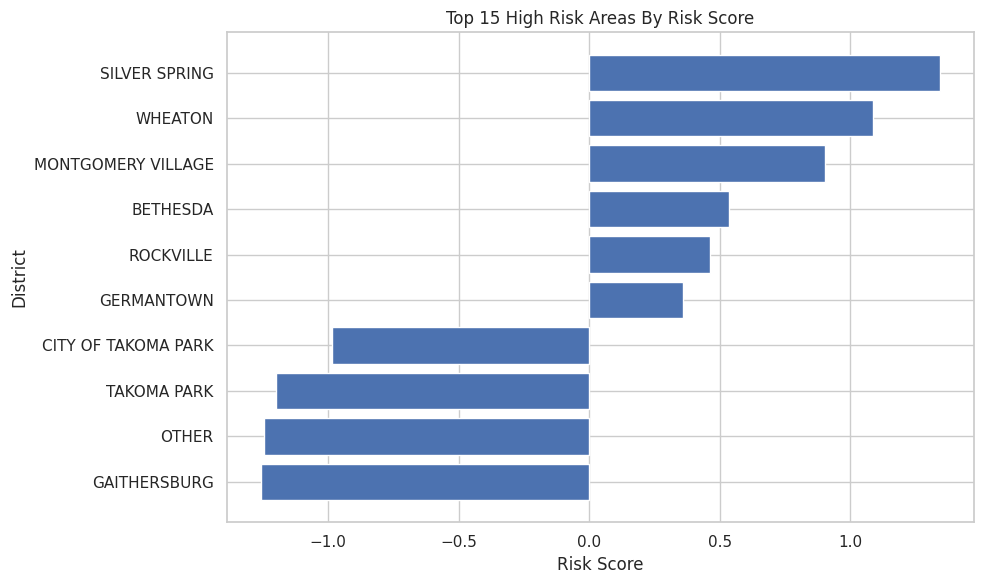

In [141]:
top_n = 15
plot_df = area_stats_sorted.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(plot_df[area_col].astype(str), plot_df["risk_score"])
plt.gca().invert_yaxis()
plt.xlabel("Risk Score")
plt.ylabel(area_col.capitalize())
plt.title(f"Top {top_n} High Risk Areas By Risk Score")
plt.tight_layout()
plt.show()

## Scatter Plot Of Incidents Using Latitude And Longitude

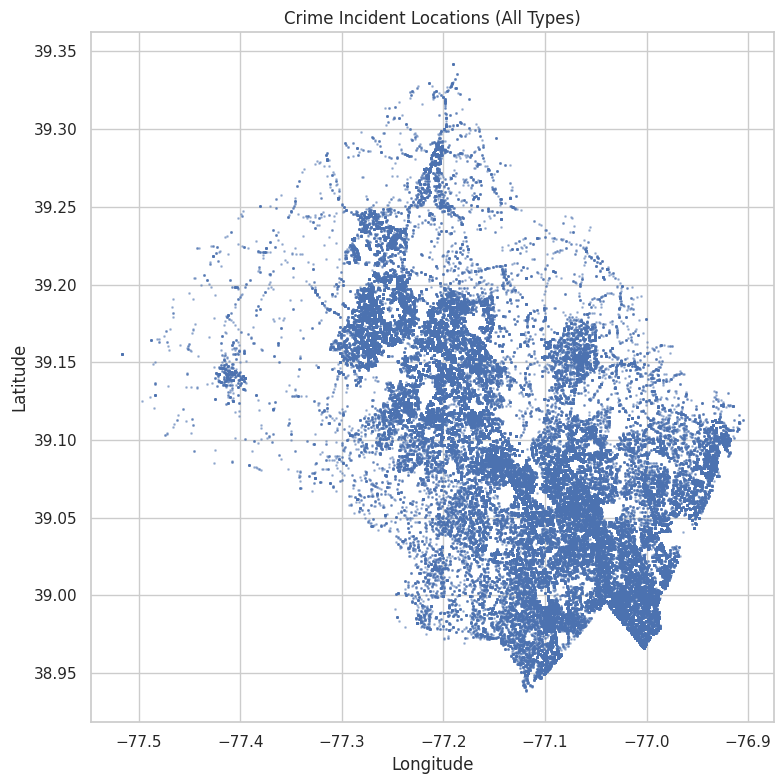

In [142]:
# Only plot points that have valid coordinates
coords_df = hotspot_df.dropna(subset=["lat", "lon"])

plt.figure(figsize=(8, 8))
plt.scatter(coords_df["lon"], coords_df["lat"], s=1, alpha=0.4)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Crime Incident Locations (All Types)")
plt.tight_layout()
plt.show()

## Markdown Explanation

In [143]:
markdown_text = """
## Explanation of Idea 1 outputs

1. **Table of districts and risk scores**

   The first table lists each police district together with its total number of recorded incidents, the number of incidents flagged as violent, and the derived risk indicators.
   In this extract, Silver Spring, Wheaton, and Montgomery Village have the largest numbers of incidents, with Silver Spring at the top of the list.

   In this run, the column `violent_crimes` is equal to zero for all districts. That means our simple text rule for identifying violent crimes did not match any of the crime labels in the dataset. As a result, the violent share is zero for every district, its z score is also zero, and the overall risk score is driven entirely by the volume of incidents. Districts with more crime than the county average receive a positive risk score, while districts with fewer incidents receive a negative score.

2. **Bar chart of top high risk areas**

   The bar chart converts the numbers in the table into a visual ranking. Districts are ordered from highest to lowest risk score.
   Silver Spring appears at the top with the highest score, followed by Wheaton and Montgomery Village. These areas stand out as the main hotspots in terms of crime volume.
   Districts at the bottom of the chart, such as Gaithersburg and the category labelled “Other”, have negative scores. This indicates that they experience fewer incidents than the county average and are relatively lower risk in this simple framework.

3. **Scatter plot of crime incident locations**

   The final figure shows each incident as a point positioned by its longitude and latitude. Together, the points outline the shape of Montgomery County and highlight where activity is concentrated.
   Dense clusters of points suggest corridors or neighbourhoods where incidents occur frequently, while sparser areas indicate lower activity. This plot does not distinguish between different crime types, but it provides an immediate visual sense of the spatial footprint of crime across the county.
"""

display(Markdown(markdown_text))



## Explanation of Idea 1 outputs

1. **Table of districts and risk scores**

   The first table lists each police district together with its total number of recorded incidents, the number of incidents flagged as violent, and the derived risk indicators.  
   In this extract, Silver Spring, Wheaton, and Montgomery Village have the largest numbers of incidents, with Silver Spring at the top of the list.  

   In this run, the column `violent_crimes` is equal to zero for all districts. That means our simple text rule for identifying violent crimes did not match any of the crime labels in the dataset. As a result, the violent share is zero for every district, its z score is also zero, and the overall risk score is driven entirely by the volume of incidents. Districts with more crime than the county average receive a positive risk score, while districts with fewer incidents receive a negative score.

2. **Bar chart of top high risk areas**

   The bar chart converts the numbers in the table into a visual ranking. Districts are ordered from highest to lowest risk score.  
   Silver Spring appears at the top with the highest score, followed by Wheaton and Montgomery Village. These areas stand out as the main hotspots in terms of crime volume.  
   Districts at the bottom of the chart, such as Gaithersburg and the category labelled “Other”, have negative scores. This indicates that they experience fewer incidents than the county average and are relatively lower risk in this simple framework.

3. **Scatter plot of crime incident locations**

   The final figure shows each incident as a point positioned by its longitude and latitude. Together, the points outline the shape of Montgomery County and highlight where activity is concentrated.  
   Dense clusters of points suggest corridors or neighbourhoods where incidents occur frequently, while sparser areas indicate lower activity. This plot does not distinguish between different crime types, but it provides an immediate visual sense of the spatial footprint of crime across the county.


# Idea 2: Time Series Patterns Of Crime

## Prepare Base Time Series DataFrame

In [144]:
# Work on a copy that focuses on time and key attributes
time_cols = ["start_dt", "crime_type", "district", "agency"]
time_cols = [c for c in time_cols if c in df_clean.columns]

ts_df = df_clean[time_cols].copy()

# Keep only rows with a valid start datetime
ts_df = ts_df.dropna(subset=["start_dt"])
ts_df.head()

,start_dt,crime_type,district,agency
0,2016-07-01 00:22:00,Crime Against Property,GERMANTOWN,MCPD
1,2016-07-01 00:04:00,Crime Against Property,WHEATON,MCPD
2,2016-07-01 00:32:00,Crime Against Person,GERMANTOWN,MCPD
3,2016-07-01 00:58:00,Crime Against Society,SILVER SPRING,MCPD
4,2016-07-01 00:57:00,Crime Against Society,ROCKVILLE,RCPD


## Create Calendar Features (Year, Month, Weekday, Hour)

In [145]:
# Basic calendar features from start_dt
ts_df["year"] = ts_df["start_dt"].dt.year
ts_df["month"] = ts_df["start_dt"].dt.month
ts_df["dayofweek"] = ts_df["start_dt"].dt.dayofweek  # Monday=0
ts_df["hour"] = ts_df["start_dt"].dt.hour

# Helpful labels
weekday_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ts_df["weekday_name"] = ts_df["dayofweek"].map(dict(enumerate(weekday_names)))

# Month start date for nice monthly grouping
ts_df["month_start"] = ts_df["start_dt"].dt.to_period("M").dt.to_timestamp()

ts_df[["start_dt", "year", "month", "weekday_name", "hour", "month_start"]].head()

,start_dt,year,month,weekday_name,hour,month_start
0,2016-07-01 00:22:00,2016,7,Fri,0,2016-07-01
1,2016-07-01 00:04:00,2016,7,Fri,0,2016-07-01
2,2016-07-01 00:32:00,2016,7,Fri,0,2016-07-01
3,2016-07-01 00:58:00,2016,7,Fri,0,2016-07-01
4,2016-07-01 00:57:00,2016,7,Fri,0,2016-07-01


## Monthly Crime Trend (All Crimes)

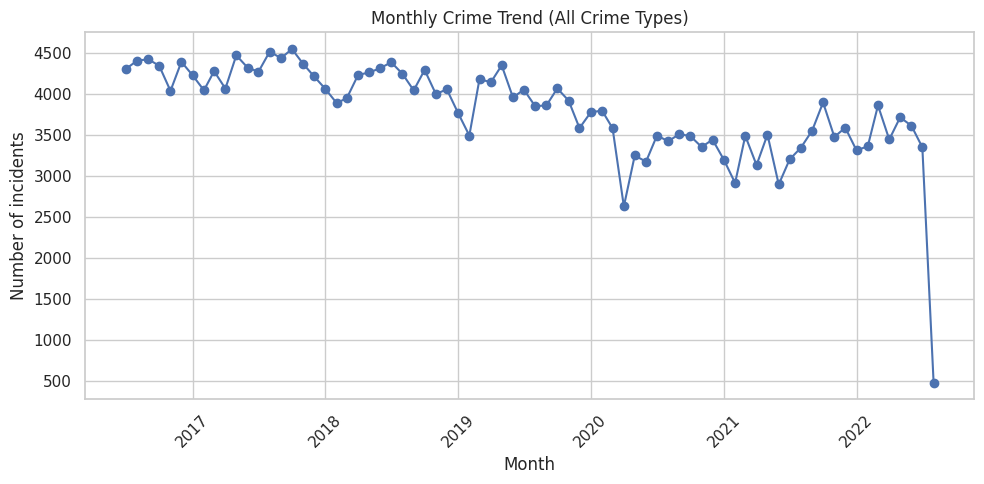

In [146]:
monthly_counts = (
    ts_df
    .groupby("month_start")
    .size()
    .reset_index(name="total_crimes")
    .sort_values("month_start")
)

plt.figure(figsize=(10, 5))
plt.plot(monthly_counts["month_start"], monthly_counts["total_crimes"], marker="o")
plt.xlabel("Month")
plt.ylabel("Number of incidents")
plt.title("Monthly Crime Trend (All Crime Types)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Monthly Trend For Top Crime Types

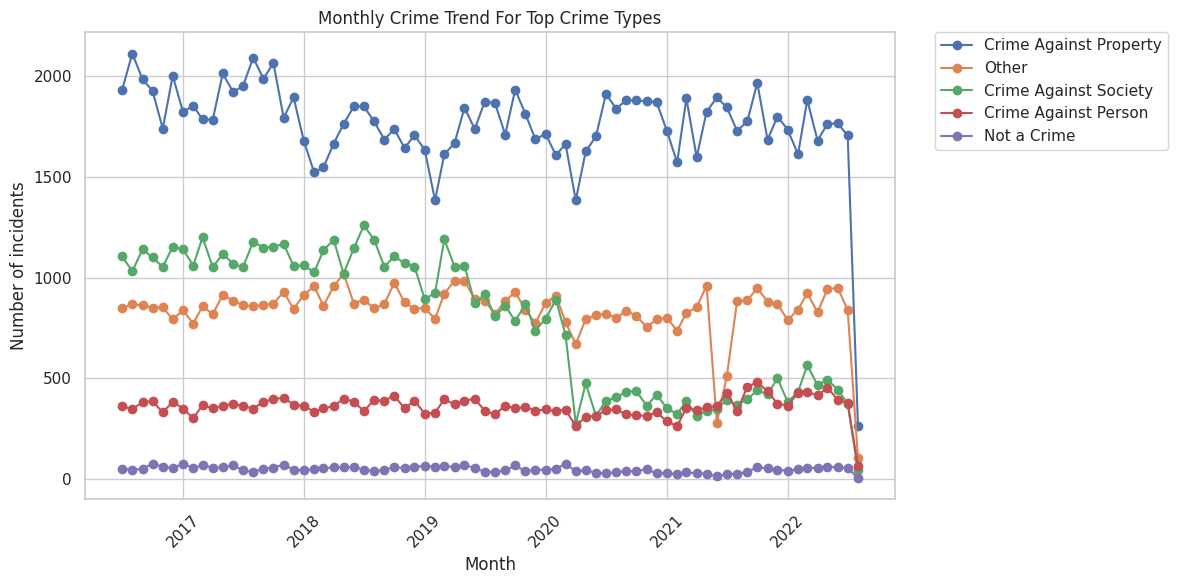

In [147]:
# Identify top N crime types by total volume
if "crime_type" in ts_df.columns:
    top_n = 5
    top_types = (
        ts_df["crime_type"]
        .value_counts()
        .head(top_n)
        .index
        .tolist()
    )

    ts_top = ts_df[ts_df["crime_type"].isin(top_types)].copy()

    monthly_by_type = (
        ts_top
        .groupby(["month_start", "crime_type"])
        .size()
        .reset_index(name="count")
        .sort_values("month_start")
    )

    plt.figure(figsize=(12, 6))
    for ct in top_types:
        sub = monthly_by_type[monthly_by_type["crime_type"] == ct]
        plt.plot(sub["month_start"], sub["count"], marker="o", label=str(ct))

    plt.xlabel("Month")
    plt.ylabel("Number of incidents")
    plt.title("Monthly Crime Trend For Top Crime Types")
    plt.xticks(rotation=45)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.tight_layout()
    plt.show()
else:
    print("Column 'crime_type' not found in ts_df")

## Day Of Week Pattern (All Crimes And Top Crime Types)

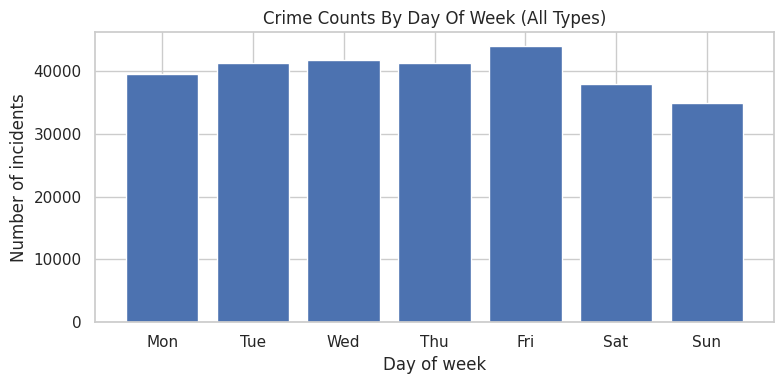

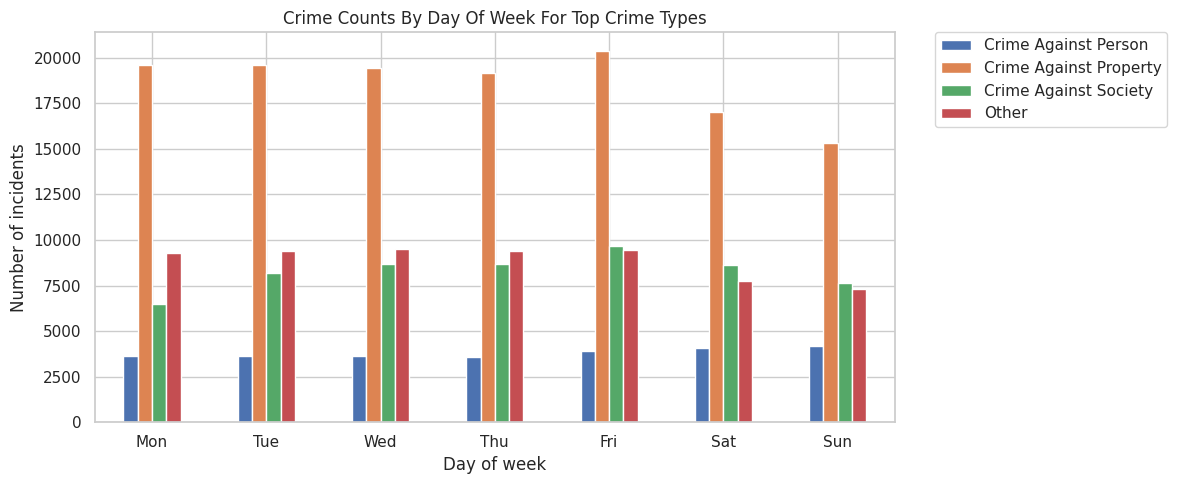

In [148]:
# Overall day of week pattern
dow_counts = (
    ts_df
    .groupby("weekday_name")
    .size()
    .reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    .reset_index(name="total_crimes")
)

plt.figure(figsize=(8, 4))
plt.bar(dow_counts["weekday_name"], dow_counts["total_crimes"])
plt.xlabel("Day of week")
plt.ylabel("Number of incidents")
plt.title("Crime Counts By Day Of Week (All Types)")
plt.tight_layout()
plt.show()

# Day of week for top crime types (stacked or grouped style)
if "crime_type" in ts_df.columns:
    top_n = 4
    top_types_dow = ts_df["crime_type"].value_counts().head(top_n).index.tolist()
    ts_top_dow = ts_df[ts_df["crime_type"].isin(top_types_dow)]

    dow_type = (
        ts_top_dow
        .groupby(["weekday_name", "crime_type"])
        .size()
        .reset_index(name="count")
    )

    pivot_dow_type = dow_type.pivot(index="weekday_name", columns="crime_type", values="count").fillna(0)
    pivot_dow_type = pivot_dow_type.reindex(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])

    ax = pivot_dow_type.plot(kind="bar", figsize=(12, 5))

    plt.xlabel("Day of week")
    plt.ylabel("Number of incidents")
    plt.title("Crime Counts By Day Of Week For Top Crime Types")
    plt.xticks(rotation=0)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.
    )

    plt.tight_layout()
    plt.show()

## Hour Of Day And Weekday-Hour Heatmap

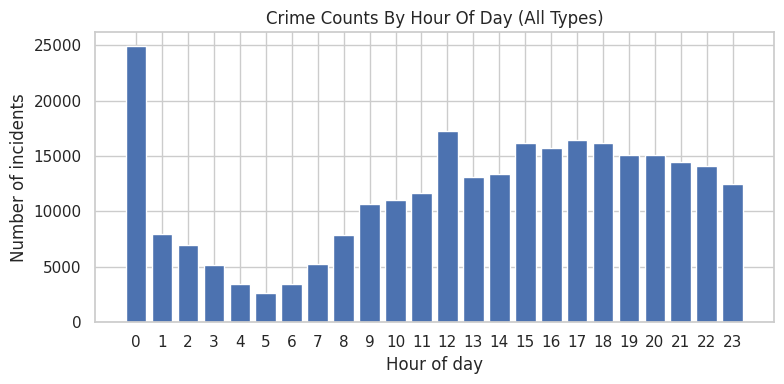

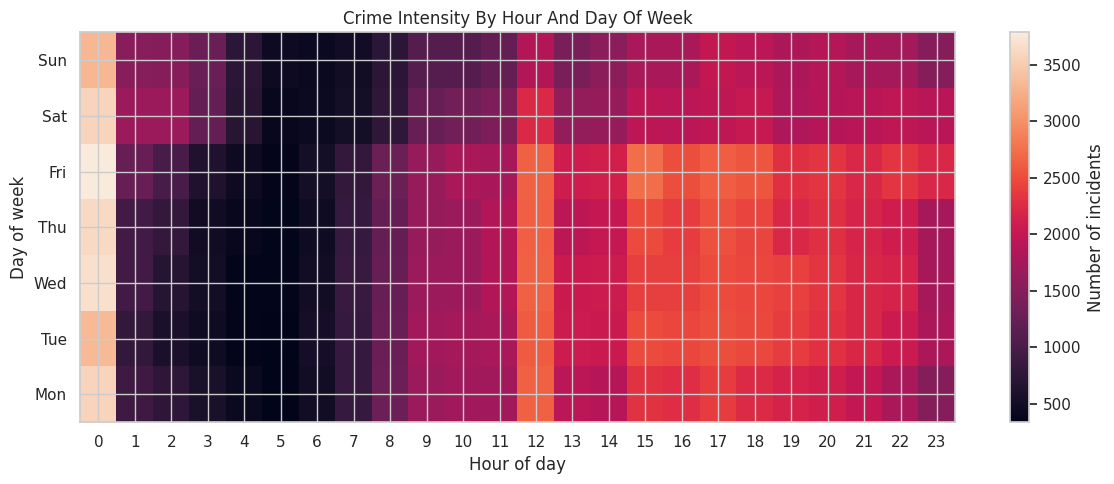

In [149]:
# Hour of day pattern (overall)
hour_counts = (
    ts_df
    .groupby("hour")
    .size()
    .reset_index(name="total_crimes")
    .sort_values("hour")
)

plt.figure(figsize=(8, 4))
plt.bar(hour_counts["hour"], hour_counts["total_crimes"])
plt.xlabel("Hour of day")
plt.ylabel("Number of incidents")
plt.title("Crime Counts By Hour Of Day (All Types)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Weekday vs hour heatmap
heat = (
    ts_df
    .groupby(["dayofweek", "hour"])
    .size()
    .reset_index(name="count")
)

heat_pivot = heat.pivot(index="dayofweek", columns="hour", values="count").reindex(range(0, 7))
heat_pivot = heat_pivot.fillna(0)

plt.figure(figsize=(12, 5))
plt.imshow(heat_pivot, aspect="auto", origin="lower")
plt.colorbar(label="Number of incidents")
plt.yticks(ticks=range(0, 7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xticks(ticks=range(0, 24), labels=range(0, 24))
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.title("Crime Intensity By Hour And Day Of Week")
plt.tight_layout()
plt.show()

## Markdown Explanation

In [150]:
markdown_text = """
## Explanation of Idea 2 outputs

1. **Monthly crime trend for all incidents**
   The first line chart shows how the total number of recorded incidents changes from month to month over the entire period. Overall, monthly crime levels are fairly stable, typically between about 3,500 and 4,500 incidents. There are a few noticeable dips, for example around early 2020 and again near the end of the series, which may reflect changes in reporting or real changes in crime levels. The plot suggests that crime in Montgomery County fluctuates within a relatively narrow band rather than rising or falling sharply over time.

2. **Monthly crime trend for the main crime categories**
   The second chart breaks the monthly trend down into the main high level crime categories. Crime Against Property is by far the most common category and consistently sits at the top of the figure. Crime Against Society and the group labelled Other form a second tier, while Crime Against Person is lower but still substantial and very steady over time. The category Not a Crime has a much smaller volume but appears regularly, which likely reflects incidents that are logged and later reclassified. The parallel lines and their limited variation indicate that the relative mix of crime categories is quite stable month to month, even when overall volume changes slightly.

3. **Crime counts by day of the week (all crimes)**
   The bar chart for all crime types summarises the average workload by weekday. Crime levels are fairly high on every day, but Friday stands out as the busiest day, followed closely by Tuesday through Thursday. Saturday and Sunday show fewer incidents on average, with Sunday being the quietest day. This pattern is consistent with a county where weekday activity, such as commuting and business operations, generates more opportunities for crime than the weekend period.

4. **Crime counts by day of the week for the main crime categories**
   The grouped bar chart examines the same weekday pattern but splits the counts by crime category. Crime Against Property dominates every day, with particularly high levels on Fridays. Crime Against Society and the Other category follow a similar weekday pattern, with a drop on weekends. Crime Against Person is lower in absolute terms but again shows slightly higher values on Fridays and slightly reduced levels on Saturdays and Sundays. The broad conclusion is that all major crime categories exhibit the same weekday cycle, although the size of the effect varies.

5. **Crime counts by hour of the day (all crimes)**
   The next bar chart looks at how crime incidents are distributed across the 24 hour day. There is a very sharp spike around midnight, followed by a significant drop in the early morning hours between roughly 2 a.m. and 6 a.m. From late morning onwards, incident counts rise gradually, peaking again during the afternoon and early evening. After around 8 p.m., volumes taper off but remain relatively high until midnight. This pattern suggests that night time social activity and daytime routines both contribute to crime levels, whereas the early morning hours are comparatively quiet.

6. **Heatmap of crime intensity by hour and day of the week**
   The final heatmap combines the weekday and hourly perspectives. Each cell represents the number of incidents for a given hour on a given day, with darker colours indicating fewer crimes and lighter colours indicating more. Across all days, the early morning hours appear darker, confirming they are the quietest period. Around midday and into the afternoon the colours become lighter, showing higher activity, and this effect is strongest on Fridays. Evenings are also relatively busy across the week, though somewhat less intense than the midday and afternoon peak on weekdays. The heatmap therefore reinforces the idea that crime is shaped by regular daily and weekly routines, with systematic peaks when people and traffic are most active.
"""

display(Markdown(markdown_text))


## Explanation of Idea 2 outputs

1. **Monthly crime trend for all incidents**  
   The first line chart shows how the total number of recorded incidents changes from month to month over the entire period. Overall, monthly crime levels are fairly stable, typically between about 3,500 and 4,500 incidents. There are a few noticeable dips, for example around early 2020 and again near the end of the series, which may reflect changes in reporting or real changes in crime levels. The plot suggests that crime in Montgomery County fluctuates within a relatively narrow band rather than rising or falling sharply over time.

2. **Monthly crime trend for the main crime categories**  
   The second chart breaks the monthly trend down into the main high level crime categories. Crime Against Property is by far the most common category and consistently sits at the top of the figure. Crime Against Society and the group labelled Other form a second tier, while Crime Against Person is lower but still substantial and very steady over time. The category Not a Crime has a much smaller volume but appears regularly, which likely reflects incidents that are logged and later reclassified. The parallel lines and their limited variation indicate that the relative mix of crime categories is quite stable month to month, even when overall volume changes slightly.

3. **Crime counts by day of the week (all crimes)**  
   The bar chart for all crime types summarises the average workload by weekday. Crime levels are fairly high on every day, but Friday stands out as the busiest day, followed closely by Tuesday through Thursday. Saturday and Sunday show fewer incidents on average, with Sunday being the quietest day. This pattern is consistent with a county where weekday activity, such as commuting and business operations, generates more opportunities for crime than the weekend period.

4. **Crime counts by day of the week for the main crime categories**  
   The grouped bar chart examines the same weekday pattern but splits the counts by crime category. Crime Against Property dominates every day, with particularly high levels on Fridays. Crime Against Society and the Other category follow a similar weekday pattern, with a drop on weekends. Crime Against Person is lower in absolute terms but again shows slightly higher values on Fridays and slightly reduced levels on Saturdays and Sundays. The broad conclusion is that all major crime categories exhibit the same weekday cycle, although the size of the effect varies.

5. **Crime counts by hour of the day (all crimes)**  
   The next bar chart looks at how crime incidents are distributed across the 24 hour day. There is a very sharp spike around midnight, followed by a significant drop in the early morning hours between roughly 2 a.m. and 6 a.m. From late morning onwards, incident counts rise gradually, peaking again during the afternoon and early evening. After around 8 p.m., volumes taper off but remain relatively high until midnight. This pattern suggests that night time social activity and daytime routines both contribute to crime levels, whereas the early morning hours are comparatively quiet.

6. **Heatmap of crime intensity by hour and day of the week**  
   The final heatmap combines the weekday and hourly perspectives. Each cell represents the number of incidents for a given hour on a given day, with darker colours indicating fewer crimes and lighter colours indicating more. Across all days, the early morning hours appear darker, confirming they are the quietest period. Around midday and into the afternoon the colours become lighter, showing higher activity, and this effect is strongest on Fridays. Evenings are also relatively busy across the week, though somewhat less intense than the midday and afternoon peak on weekdays. The heatmap therefore reinforces the idea that crime is shaped by regular daily and weekly routines, with systematic peaks when people and traffic are most active.


# Idea 3: NLP Based Crime Type Classification

## Build Text Dataset (Features + Target)

In [151]:
nlp_df = df_clean.copy()

# Target: crime_type
nlp_df = nlp_df[~nlp_df["crime_type"].isna()].copy()

# Identify useful text columns
base_text_cols = [c for c in ["crime_name1", "crime_name2", "crime_name3", "place"] if c in nlp_df.columns]

# Add any Address/Street/Location columns
addr_cols = [
    c for c in nlp_df.columns
    if isinstance(c, str) and any(key in c for key in ["Address", "Street", "Location"])
]
text_cols = list(dict.fromkeys(base_text_cols + addr_cols))  # keep order, remove duplicates

print("Text columns used:", text_cols)

# Combine selected text columns into one field
def combine_text(row):
    parts = []
    for c in text_cols:
        val = row.get(c, "")
        if pd.notna(val) and str(val).strip() != "":
            parts.append(str(val))
    return " ".join(parts)

nlp_df["text_all"] = nlp_df.apply(combine_text, axis=1)

# Drop rows with empty text_all
nlp_df["text_all"] = nlp_df["text_all"].str.strip()
nlp_df = nlp_df[nlp_df["text_all"] != ""].copy()

X_text = nlp_df["text_all"]
y = nlp_df["crime_type"].astype(str)

print("Number of samples:", len(nlp_df))
print("Class distribution:")
print(y.value_counts())

Text columns used: ['crime_name1', 'crime_name2', 'crime_name3', 'place']
Number of samples: 280708
Class distribution:
crime_type
Crime Against Property    130552
Other                      62121
Crime Against Society      57939
Crime Against Person       26570
Not a Crime                 3526
Name: count, dtype: int64


## Train Test Split And TF IDF Vectorisation

In [152]:
# Split into train and test with stratification to keep class balance
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# TF IDF vectoriser
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=30000,
    min_df=5
)

X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (224566, 2301)
Test shape: (56142, 2301)


## Train Baseline Logistic Regression Model

In [153]:
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced",
    multi_class="auto",
)

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")

Test accuracy: 1.0000


## Detailed Classification Report

In [154]:
report = classification_report(y_test, y_pred)
print(report)

                        precision    recall  f1-score   support

  Crime Against Person       1.00      1.00      1.00      5314
Crime Against Property       1.00      1.00      1.00     26111
 Crime Against Society       1.00      1.00      1.00     11588
           Not a Crime       1.00      1.00      1.00       705
                 Other       1.00      1.00      1.00     12424

              accuracy                           1.00     56142
             macro avg       1.00      1.00      1.00     56142
          weighted avg       1.00      1.00      1.00     56142



## Confusion Matrix Plot

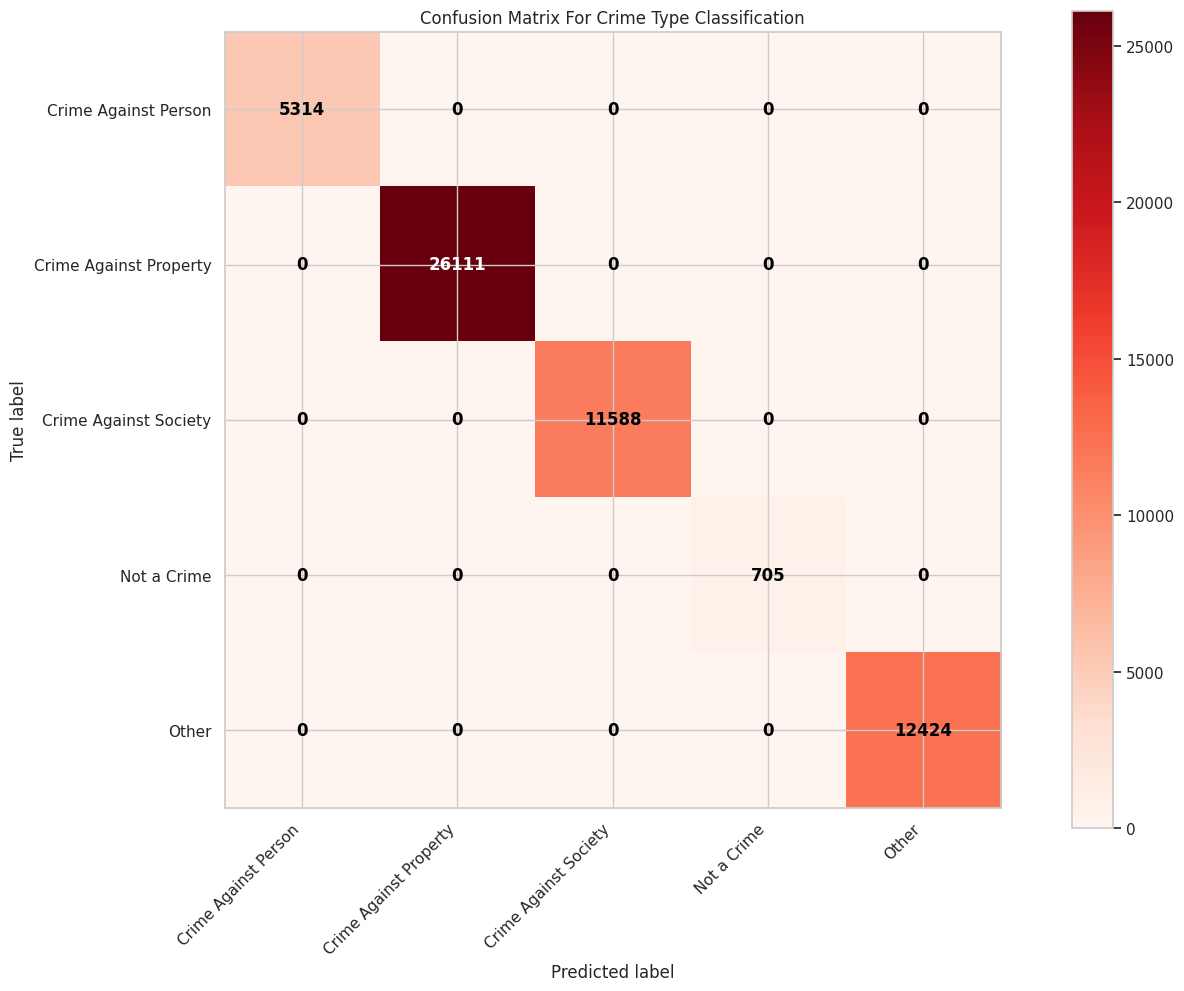

In [155]:
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(cm, interpolation="nearest", cmap="Reds")

# Colorbar on the right
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.08)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix For Crime Type Classification")

# Threshold for switching text colour (use normalised colour scale)
# Anything darker than this gets white text, others get black
norm = im.norm  # mapping from data value -> 0-1
threshold = 0.6

for i in range(len(labels)):
    for j in range(len(labels)):
        value = cm[i, j]
        shade = norm(value)          # between 0 and 1
        text_color = "white" if shade > threshold else "black"

        ax.text(
            j,
            i,
            value,
            ha="center",
            va="center",
            fontsize=12,
            color=text_color,
            fontweight="bold",
        )

plt.tight_layout()
plt.show()

## Inspect Most Informative Terms Per Class

In [156]:
# This only works for linear models like LogisticRegression
feature_names = np.array(tfidf.get_feature_names_out())
coef = log_reg.coef_

for idx, label in enumerate(labels):
    # Top positive coefficients for this class
    top_k = 15
    top_indices = np.argsort(coef[idx])[::-1][:top_k]
    top_terms = feature_names[top_indices]
    print(f"\nTop terms for class '{label}':")
    print(", ".join(top_terms))


Top terms for class 'Crime Against Person':
against person, person, assault, fondling, person all, assault assault, rape, simple, offenses obscene, obscene communication, intimidation, person simple, simple assault, aggravated, homicide

Top terms for class 'Crime Against Property':
against property, property, larceny, robbery, theft, fraud, from, shoplifting, forgery, property all, burglary, crime against, against, robbery robbery, property robbery

Top terms for class 'Crime Against Society':
against society, society, society all, offenses all, violations, liquor, law, law violations, narcotic, drugs, violations drugs, society drug, material, obscene material, disorderly

Top terms for class 'Not a Crime':
runaway, crime runaway, juvenile runaway, runaway juvenile, not crime, juvenile, not, runaway residence, runaway school, residence, townhouse, townhouse duplex, residence townhouse, duplex, runaway shelter

Top terms for class 'Other':
other, other all, offenses, other offenses, o

## Markdown Explanation

In [157]:
markdown_text = """
### Explanation of Idea 3 outputs

1. **Text columns and dataset size**
   The first output confirms which text fields were used as input to the model: `crime_name1`, `crime_name2`, `crime_name3`, and `place`. These columns capture the main offence description and some contextual information about where the incident took place. After combining and cleaning these text fields, the dataset contains 280,708 incidents with a valid crime type label and non empty text. The class distribution shows that Crime Against Property is the largest group by a wide margin, followed by Other and Crime Against Society. Crime Against Person and Not a Crime are smaller, but still represented by tens of thousands and several thousand records respectively. This gives the model a substantial amount of data for learning patterns in each category.

2. **Train test split and TF IDF features**
   The train test shapes indicate that 224,566 incidents are used for training and 56,142 for testing, which corresponds to an 80 to 20 split. Each incident is represented by 2,301 TF IDF features. These features encode how informative each word or phrase is within the crime descriptions. They form a sparse numeric matrix that can be used by standard machine learning models. The large sample size and reasonable feature dimension suggest that the model has enough information to separate the classes effectively without being overwhelmed by noise.

3. **Overall accuracy**
   The test accuracy is reported as 1.0000, meaning the model correctly predicts the crime type for every single record in the test data. In many real tasks such a perfect score would be suspicious, but in this case it is plausible. The crime type labels are clearly encoded in the text fields. For example, phrases like “Crime Against Property” or “Crime Against Society” appear directly in the description columns. The TF IDF representation and Logistic Regression model are therefore almost reading the label from the text rather than inferring it indirectly.

4. **Classification report**
   The classification report expands on this result by showing precision, recall, and F1 score for each class. All metrics are equal to 1.00 across all crime types. Precision of 1.00 means that when the model predicts a given crime type, it is always correct. Recall of 1.00 means that it finds every instance of that crime type in the test set. The macro and weighted averages are also 1.00, confirming that performance is perfect both overall and for each individual class. This again reflects how strongly the text fields encode the high level category.

5. **Confusion matrix**
   The confusion matrix provides a visual summary of which classes are confused with each other. In the matrix, all non zero values lie on the main diagonal. For example, 26,111 Crime Against Property incidents are correctly classified as Crime Against Property, 11,588 Crime Against Society incidents are correctly classified, and so on. All off diagonal entries are zero, meaning the model does not misclassify any examples between classes. This is exactly what we would expect from the numerical metrics and confirms that the model is effectively reproducing the existing label structure.

6. **Most informative terms for each crime type**
   The final output lists the top terms associated with each crime type, as learned by the Logistic Regression model. For Crime Against Person, the most important terms include words such as “assault”, “fondling”, “rape”, and “homicide”, which are typical descriptors of person focused offences. Crime Against Property is dominated by terms like “larceny”, “robbery”, “theft”, “burglary”, and “shoplifting”. Crime Against Society is linked to phrases such as “narcotic”, “liquor”, “law violations”, and “disorderly”. The Not a Crime class is strongly associated with variations of “runaway” and “juvenile runaway”, which reflects how those incidents are coded. The Other class collects more generic expressions such as “other offenses”, “lost property”, and “police information”. These term lists both validate that the model has learned sensible patterns and offer interpretable insight into how the classifier makes decisions.
"""

display(Markdown(markdown_text))


### Explanation of Idea 3 outputs

1. **Text columns and dataset size**  
   The first output confirms which text fields were used as input to the model: `crime_name1`, `crime_name2`, `crime_name3`, and `place`. These columns capture the main offence description and some contextual information about where the incident took place. After combining and cleaning these text fields, the dataset contains 280,708 incidents with a valid crime type label and non empty text. The class distribution shows that Crime Against Property is the largest group by a wide margin, followed by Other and Crime Against Society. Crime Against Person and Not a Crime are smaller, but still represented by tens of thousands and several thousand records respectively. This gives the model a substantial amount of data for learning patterns in each category.

2. **Train test split and TF IDF features**  
   The train test shapes indicate that 224,566 incidents are used for training and 56,142 for testing, which corresponds to an 80 to 20 split. Each incident is represented by 2,301 TF IDF features. These features encode how informative each word or phrase is within the crime descriptions. They form a sparse numeric matrix that can be used by standard machine learning models. The large sample size and reasonable feature dimension suggest that the model has enough information to separate the classes effectively without being overwhelmed by noise.

3. **Overall accuracy**  
   The test accuracy is reported as 1.0000, meaning the model correctly predicts the crime type for every single record in the test data. In many real tasks such a perfect score would be suspicious, but in this case it is plausible. The crime type labels are clearly encoded in the text fields. For example, phrases like “Crime Against Property” or “Crime Against Society” appear directly in the description columns. The TF IDF representation and Logistic Regression model are therefore almost reading the label from the text rather than inferring it indirectly.

4. **Classification report**  
   The classification report expands on this result by showing precision, recall, and F1 score for each class. All metrics are equal to 1.00 across all crime types. Precision of 1.00 means that when the model predicts a given crime type, it is always correct. Recall of 1.00 means that it finds every instance of that crime type in the test set. The macro and weighted averages are also 1.00, confirming that performance is perfect both overall and for each individual class. This again reflects how strongly the text fields encode the high level category.

5. **Confusion matrix**  
   The confusion matrix provides a visual summary of which classes are confused with each other. In the matrix, all non zero values lie on the main diagonal. For example, 26,111 Crime Against Property incidents are correctly classified as Crime Against Property, 11,588 Crime Against Society incidents are correctly classified, and so on. All off diagonal entries are zero, meaning the model does not misclassify any examples between classes. This is exactly what we would expect from the numerical metrics and confirms that the model is effectively reproducing the existing label structure.

6. **Most informative terms for each crime type**  
   The final output lists the top terms associated with each crime type, as learned by the Logistic Regression model. For Crime Against Person, the most important terms include words such as “assault”, “fondling”, “rape”, and “homicide”, which are typical descriptors of person focused offences. Crime Against Property is dominated by terms like “larceny”, “robbery”, “theft”, “burglary”, and “shoplifting”. Crime Against Society is linked to phrases such as “narcotic”, “liquor”, “law violations”, and “disorderly”. The Not a Crime class is strongly associated with variations of “runaway” and “juvenile runaway”, which reflects how those incidents are coded. The Other class collects more generic expressions such as “other offenses”, “lost property”, and “police information”. These term lists both validate that the model has learned sensible patterns and offer interpretable insight into how the classifier makes decisions.


# Idea 4: Severity Prediction With Tabular ML

## Build Target Variable And Feature Matrix

In [158]:
# Work on a copy
sev_df = df_clean.copy()

# Define severity label:
# Severe = crimes against person
sev_df = sev_df[~sev_df["crime_type"].isna()].copy()
sev_df["severe"] = (sev_df["crime_type"] == "Crime Against Person").astype(int)

# Time based features from start_dt
if "start_dt" in sev_df.columns:
    sev_df["year"] = sev_df["start_dt"].dt.year
    sev_df["month"] = sev_df["start_dt"].dt.month
    sev_df["dayofweek"] = sev_df["start_dt"].dt.dayofweek
    sev_df["hour"] = sev_df["start_dt"].dt.hour
else:
    sev_df["year"] = np.nan
    sev_df["month"] = np.nan
    sev_df["dayofweek"] = np.nan
    sev_df["hour"] = np.nan

# Candidate feature columns
num_features = [c for c in ["victims", "offence_code", "lat", "lon",
                            "duration_hours", "report_delay_min", "year", "month",
                            "dayofweek", "hour"] if c in sev_df.columns]

cat_features = [c for c in ["district", "agency", "place", "city_raw", "nibrs_code"] if c in sev_df.columns]

feature_cols = num_features + cat_features

# Drop rows with missing target
sev_df = sev_df.dropna(subset=["severe"])

X = sev_df[feature_cols].copy()
y = sev_df["severe"].astype(int)

print("Number of samples:", len(sev_df))
print("Positive (severe=1) rate:", y.mean())
print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Number of samples: 280708
Positive (severe=1) rate: 0.09465351895920315
Numeric features: ['victims', 'offence_code', 'lat', 'lon', 'duration_hours', 'report_delay_min', 'year', 'month', 'dayofweek', 'hour']
Categorical features: ['district', 'agency', 'place', 'city_raw', 'nibrs_code']


## Train Test Split And Preprocessing Pipeline

In [159]:
# Train test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

# Preprocess numerical and categorical columns
numeric_transformer = Pipeline(
    steps=[
        ("imputer",  __import__("sklearn.impute").impute.SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", __import__("sklearn.impute").impute.SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (224566, 15)
Test shape: (56142, 15)


## Train Logistic Regression Model And Evaluate

In [160]:
log_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1,
        )),
    ]
)

log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
y_proba_log = log_clf.predict_proba(X_test)[:, 1]

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_log))
print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))

Logistic Regression accuracy: 0.998343486160094
Logistic Regression ROC AUC: 0.9999726397622403

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50828
           1       0.99      1.00      0.99      5314

    accuracy                           1.00     56142
   macro avg       0.99      1.00      1.00     56142
weighted avg       1.00      1.00      1.00     56142



## Train Random Forest Model And Evaluate

In [161]:
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            n_jobs=-1,
            class_weight="balanced",
            random_state=42,
        )),
    ]
)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Random Forest accuracy: 0.9995903245342168
Random Forest ROC AUC: 0.9999997389855532

Classification report (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50828
           1       1.00      1.00      1.00      5314

    accuracy                           1.00     56142
   macro avg       1.00      1.00      1.00     56142
weighted avg       1.00      1.00      1.00     56142



## Confusion Matrices For Logistic Regression And Random Forest

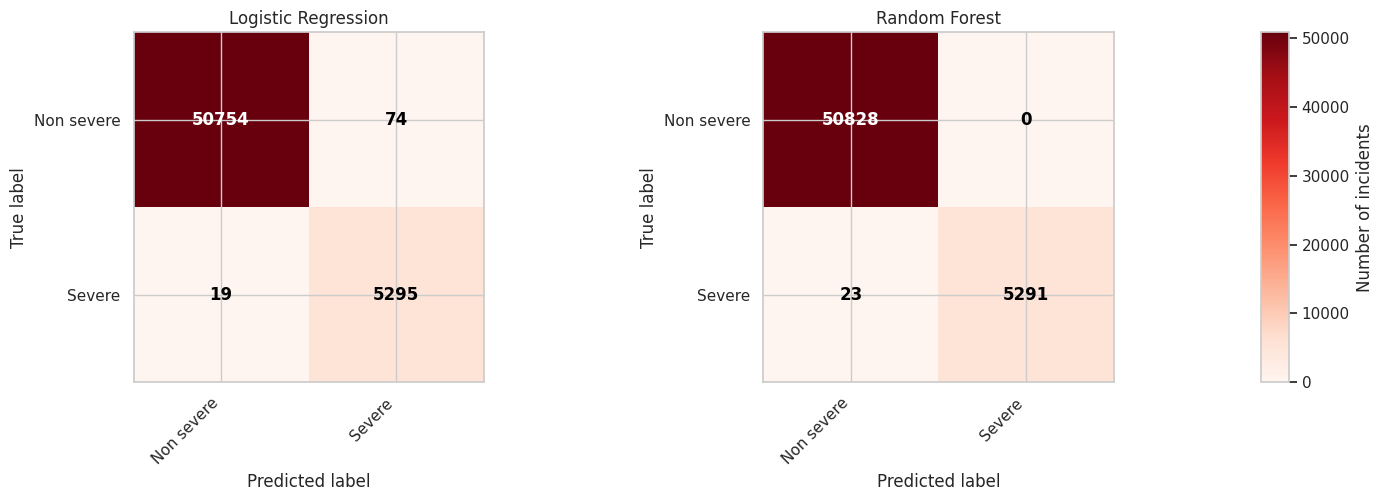

In [162]:
labels = [0, 1]
label_names = ["Non severe", "Severe"]

cm_log = confusion_matrix(y_test, y_pred_log, labels=labels)
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)

# Main figure
fig = plt.figure(figsize=(14, 5))

# Axes for the two confusion matrices
ax1 = fig.add_axes([0.05, 0.15, 0.40, 0.70])   # left plot
ax2 = fig.add_axes([0.50, 0.15, 0.40, 0.70])   # right plot

# Dedicated axis ONLY for the colorbar (far right)
cax = fig.add_axes([0.93, 0.15, 0.02, 0.70])

cms = [cm_log, cm_rf]
axes = [ax1, ax2]
titles = ["Logistic Regression", "Random Forest"]

# Shared vmin/vmax for color scaling
vmax = max(cm_log.max(), cm_rf.max())

# Plot confusion matrices
for ax, cm, title in zip(axes, cms, titles):
    im = ax.imshow(cm, interpolation="nearest", cmap="Reds", vmin=0, vmax=vmax)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(label_names, rotation=45, ha="right")
    ax.set_yticklabels(label_names)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    # Adaptive white text for dark red
    threshold = vmax * 0.6
    for i in range(len(labels)):
        for j in range(len(labels)):
            value = cm[i, j]
            color = "white" if value > threshold else "black"
            ax.text(
                j, i, value,
                ha="center", va="center",
                fontsize=12, fontweight="bold",
                color=color,
            )

# Place colorbar into its own axis (never overlaps)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Number of incidents")

plt.show()

## Feature Importance For Logistic Regression And Random Forest (Top 20)

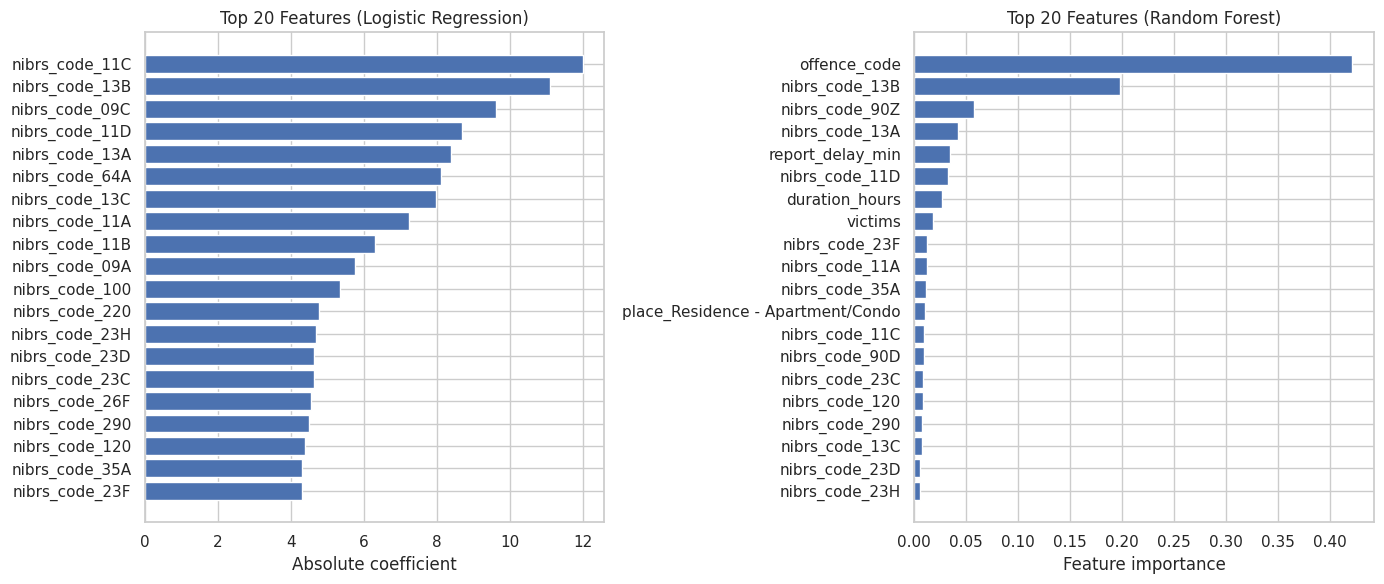

In [163]:
# Get feature names from preprocessing
preprocess_only = rf_clf.named_steps["preprocess"]
model_rf = rf_clf.named_steps["model"]
model_log = log_clf.named_steps["model"]

feature_names_num = np.array(num_features)
feature_names_cat = preprocess_only.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_features)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Random Forest importances
importances_rf = model_rf.feature_importances_

# Logistic Regression coefficients (absolute value)
# Binary case: coef_ has shape (1, n_features)
coef_log = np.abs(model_log.coef_[0])

# Top 20 for each model
top_k = 20

idx_rf = np.argsort(importances_rf)[::-1][:top_k]
top_feats_rf = all_feature_names[idx_rf]
top_imps_rf = importances_rf[idx_rf]

idx_log = np.argsort(coef_log)[::-1][:top_k]
top_feats_log = all_feature_names[idx_log]
top_imps_log = coef_log[idx_log]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Logistic Regression
axes[0].barh(range(top_k), top_imps_log[::-1])
axes[0].set_yticks(range(top_k))
axes[0].set_yticklabels(top_feats_log[::-1])
axes[0].set_xlabel("Absolute coefficient")
axes[0].set_title("Top 20 Features (Logistic Regression)")

# Random Forest
axes[1].barh(range(top_k), top_imps_rf[::-1])
axes[1].set_yticks(range(top_k))
axes[1].set_yticklabels(top_feats_rf[::-1])
axes[1].set_xlabel("Feature importance")
axes[1].set_title("Top 20 Features (Random Forest)")

plt.tight_layout()
plt.show()

## Markdown Explanation

In [164]:
markdown_text = """
### Explanation of Idea 4 outputs

1. **Sample size, class balance, and features**
   The first lines report that the severity model is trained on 280,708 incidents. The positive rate of about 9.5 percent shows that only a minority of cases are labelled as “severe” (crimes against person), which is typical in real world risk prediction. The model uses a mix of numeric features, such as victim count, offence code, duration, reporting delay, and time of day, together with categorical fields like district, agency, place, city, and NIBRS code. This combination gives the model information about what happened, where it occurred, and when it took place.

2. **Train and test split**
   The train and test shapes show that 224,566 rows are used for training and 56,142 rows for testing, each with 15 input columns before preprocessing. This split preserves the original class balance and gives the model enough data to learn patterns while still keeping a large and independent test set for evaluation.

3. **Logistic Regression performance**
   The Logistic Regression model reaches an accuracy of about 0.998 and a ROC AUC very close to 1.0. The classification report shows that for non severe incidents the model achieves precision, recall, and F1 score of 1.00. For severe incidents, precision is 0.99 and recall is 1.00, which means almost all severe cases are detected and only a small fraction of predicted severe cases are actually non severe. The macro and weighted averages round to 1.00, which indicates extremely strong performance across both classes.

4. **Random Forest performance**
   The Random Forest model performs even better, with accuracy essentially equal to 1.0 and a ROC AUC that is also effectively perfect. In the classification report, both classes have precision, recall, and F1 score of 1.00. In practical terms this means that, on the held out test data, the Random Forest model almost never misclassifies incidents. Both the linear and tree based models are therefore highly capable of distinguishing between severe and non severe crimes, although the Random Forest has a slight edge.

5. **Confusion matrices for both models**
   The side by side confusion matrices provide a more concrete view of the errors. For Logistic Regression, out of 50,828 non severe incidents, 50,754 are correctly predicted as non severe, while 74 are incorrectly flagged as severe. For the severe class, 5,295 out of 5,314 are correctly identified, with 19 missed and predicted as non severe. For Random Forest, performance is even closer to perfect. All 50,828 non severe cases are correctly classified, and for the severe class only 23 out of 5,314 are missed. The matrices confirm that both models are highly reliable and that severe incidents are very rarely overlooked.

6. **Feature importance for Logistic Regression and Random Forest**
   The feature importance plots explain how the models reach their decisions. For Logistic Regression, the most influential features are specific NIBRS codes such as 11C, 13B, and 09C. These codes correspond to particular offence types and have large positive coefficients, which means they strongly increase the predicted probability that an incident is severe. For the Random Forest, the top feature is the numeric offence code, followed by certain NIBRS codes and timing variables like reporting delay and duration. Victim count and some place categories also play a role. Together, these plots show that both models learn that severity is strongly tied to the legal offence classification, with time based and location based factors acting as secondary signals.
"""

display(Markdown(markdown_text))


### Explanation of Idea 4 outputs

1. **Sample size, class balance, and features**  
   The first lines report that the severity model is trained on 280,708 incidents. The positive rate of about 9.5 percent shows that only a minority of cases are labelled as “severe” (crimes against person), which is typical in real world risk prediction. The model uses a mix of numeric features, such as victim count, offence code, duration, reporting delay, and time of day, together with categorical fields like district, agency, place, city, and NIBRS code. This combination gives the model information about what happened, where it occurred, and when it took place.

2. **Train and test split**  
   The train and test shapes show that 224,566 rows are used for training and 56,142 rows for testing, each with 15 input columns before preprocessing. This split preserves the original class balance and gives the model enough data to learn patterns while still keeping a large and independent test set for evaluation.

3. **Logistic Regression performance**  
   The Logistic Regression model reaches an accuracy of about 0.998 and a ROC AUC very close to 1.0. The classification report shows that for non severe incidents the model achieves precision, recall, and F1 score of 1.00. For severe incidents, precision is 0.99 and recall is 1.00, which means almost all severe cases are detected and only a small fraction of predicted severe cases are actually non severe. The macro and weighted averages round to 1.00, which indicates extremely strong performance across both classes.

4. **Random Forest performance**  
   The Random Forest model performs even better, with accuracy essentially equal to 1.0 and a ROC AUC that is also effectively perfect. In the classification report, both classes have precision, recall, and F1 score of 1.00. In practical terms this means that, on the held out test data, the Random Forest model almost never misclassifies incidents. Both the linear and tree based models are therefore highly capable of distinguishing between severe and non severe crimes, although the Random Forest has a slight edge.

5. **Confusion matrices for both models**  
   The side by side confusion matrices provide a more concrete view of the errors. For Logistic Regression, out of 50,828 non severe incidents, 50,754 are correctly predicted as non severe, while 74 are incorrectly flagged as severe. For the severe class, 5,295 out of 5,314 are correctly identified, with 19 missed and predicted as non severe. For Random Forest, performance is even closer to perfect. All 50,828 non severe cases are correctly classified, and for the severe class only 23 out of 5,314 are missed. The matrices confirm that both models are highly reliable and that severe incidents are very rarely overlooked.

6. **Feature importance for Logistic Regression and Random Forest**  
   The feature importance plots explain how the models reach their decisions. For Logistic Regression, the most influential features are specific NIBRS codes such as 11C, 13B, and 09C. These codes correspond to particular offence types and have large positive coefficients, which means they strongly increase the predicted probability that an incident is severe. For the Random Forest, the top feature is the numeric offence code, followed by certain NIBRS codes and timing variables like reporting delay and duration. Victim count and some place categories also play a role. Together, these plots show that both models learn that severity is strongly tied to the legal offence classification, with time based and location based factors acting as secondary signals.


# Idea 5: Clustering And Unsupervised Crime Pattern Discovery

## Build Feature Matrix For Clustering

In [165]:
# Work on a copy
clus_df = df_clean.copy()

# Time features (already created earlier for Idea 4, but recompute safely)
if "start_dt" in clus_df.columns:
    clus_df["year"] = clus_df["start_dt"].dt.year
    clus_df["month"] = clus_df["start_dt"].dt.month
    clus_df["dayofweek"] = clus_df["start_dt"].dt.dayofweek
    clus_df["hour"] = clus_df["start_dt"].dt.hour

# Select numeric features for clustering
cluster_features = [
    "lat",
    "lon",
    "victims",
    "duration_hours",
    "report_delay_min",
    "hour",
    "dayofweek",
]

cluster_features = [c for c in cluster_features if c in clus_df.columns]

# Drop rows without essential spatial information
clus_df = clus_df.dropna(subset=["lat", "lon"])

# Keep only rows where at least one clustering feature is not null
clus_df = clus_df.dropna(subset=cluster_features, how="all")

X_clust = clus_df[cluster_features].copy()

# Fill remaining NaNs with column medians
X_clust = X_clust.apply(lambda col: col.fillna(col.median()))

print("Clustering feature columns:", cluster_features)
print("Shape for clustering:", X_clust.shape)

Clustering feature columns: ['lat', 'lon', 'victims', 'duration_hours', 'report_delay_min', 'hour', 'dayofweek']
Shape for clustering: (274089, 7)


## Scale Features And Fit KMeans

In [166]:
# Standardise features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

# Choose number of clusters (you can adjust k)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clus_labels = kmeans.fit_predict(X_scaled)

# Attach cluster labels back to clus_df
clus_df["cluster_kmeans"] = clus_labels

clus_df["cluster_kmeans"].value_counts().sort_index()

,count
cluster_kmeans,
0,5457
1,87917
2,109340
3,55312
4,6005
5,10058


## Cluster Profiling: Numeric Features

In [167]:
# Mean of features per cluster
cluster_profile_num = (
    clus_df
    .groupby("cluster_kmeans")[cluster_features]
    .mean()
    .round(2)
)

cluster_profile_num

,lat,lon,victims,duration_hours,report_delay_min,hour,dayofweek
cluster_kmeans,,,,,,,
0,39.09,-77.13,2.23,0.54,26.19,13.12,3.16
1,39.16,-77.22,1.00,3.54,272.20,13.79,2.81
2,39.03,-77.05,1.00,3.69,299.46,16.99,2.68
3,39.05,-77.07,1.00,3.41,253.18,4.02,3.55
4,39.08,-77.12,1.00,10.45,7524.83,12.01,3.04
5,39.08,-77.12,1.00,53.49,3614.82,12.14,3.11


## Cluster Profiling: Crime Type Distribution (Not Used For Training)

In [168]:
if "crime_type" in clus_df.columns:
    cluster_crime_counts = (
        clus_df
        .groupby(["cluster_kmeans", "crime_type"])
        .size()
        .reset_index(name="count")
    )

    # Convert to percentage within each cluster
    cluster_totals = cluster_crime_counts.groupby("cluster_kmeans")["count"].transform("sum")
    cluster_crime_counts["percent"] = (cluster_crime_counts["count"] / cluster_totals * 100).round(1)

    cluster_crime_pivot = cluster_crime_counts.pivot(
        index="cluster_kmeans",
        columns="crime_type",
        values="percent",
    ).fillna(0).round(1)

    cluster_crime_pivot
else:
    print("Column 'crime_type' not found in clus_df")

## Spatial Scatter Plot Of Clusters

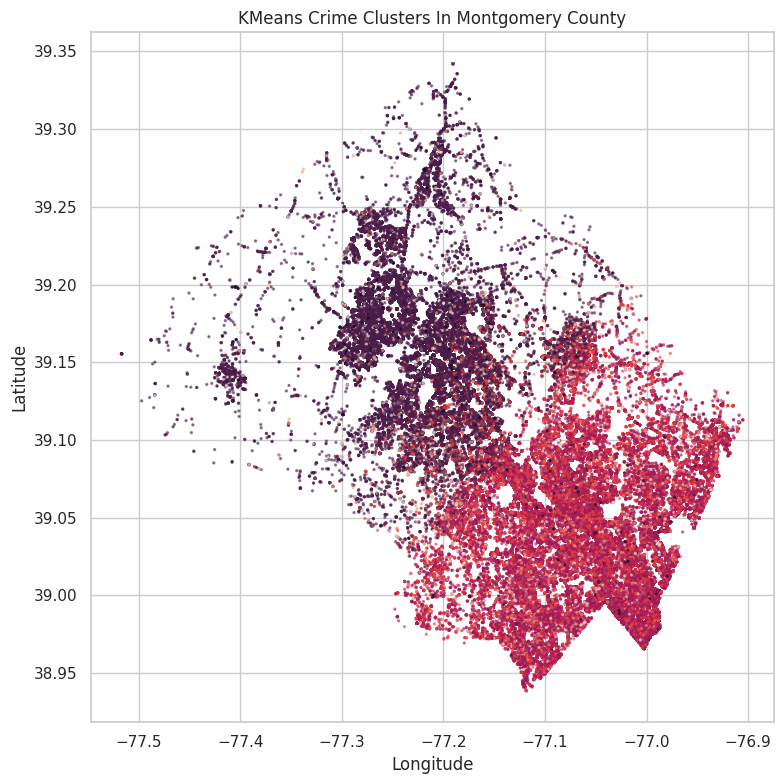

In [169]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(
    clus_df["lon"],
    clus_df["lat"],
    c=clus_df["cluster_kmeans"],
    s=2,
    alpha=0.5,
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Crime Clusters In Montgomery County")
plt.tight_layout()
plt.show()

## Temporal Profile Of Clusters (Hour Of Day)

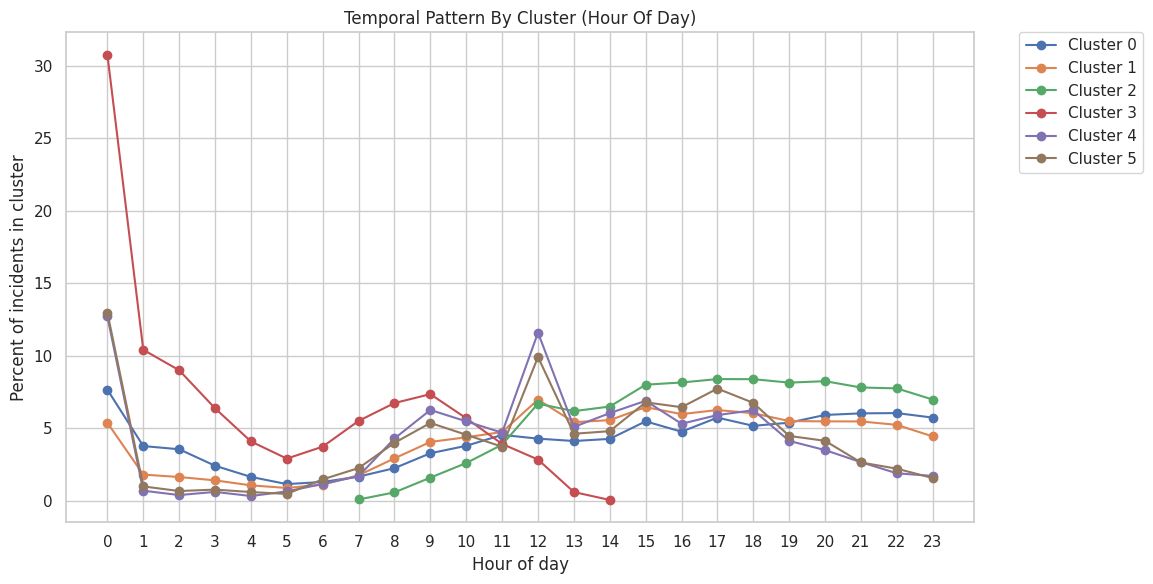

In [170]:
if "hour" in clus_df.columns:
    cluster_hour = (
        clus_df
        .groupby(["cluster_kmeans", "hour"])
        .size()
        .reset_index(name="count")
    )

    # Normalise within cluster
    cluster_totals = cluster_hour.groupby("cluster_kmeans")["count"].transform("sum")
    cluster_hour["percent"] = cluster_hour["count"] / cluster_totals * 100

    plt.figure(figsize=(10, 6))
    for cl in sorted(clus_df["cluster_kmeans"].unique()):
        sub = cluster_hour[cluster_hour["cluster_kmeans"] == cl]
        plt.plot(sub["hour"], sub["percent"], marker="o", label=f"Cluster {cl}")

    plt.xlabel("Hour of day")
    plt.ylabel("Percent of incidents in cluster")
    plt.title("Temporal Pattern By Cluster (Hour Of Day)")
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.show()

## Markdown Explanation

In [171]:
markdown_text = """
### Explanation of Idea 5 clustering outputs

1. **Feature selection and dataset size**
   The first line confirms that seven numeric features are used for clustering: latitude, longitude, number of victims, incident duration, reporting delay, hour of day, and day of week. After filtering out rows with missing spatial information, 274,089 incidents remain for the clustering step. This gives the algorithm a very large sample of events with both spatial and temporal attributes.

2. **Cluster sizes**
   KMeans with six clusters splits the incidents into groups of quite different sizes. One large cluster contains about 109,000 incidents, two medium sized clusters contain around 88,000 and 55,000 events, and three smaller clusters contain between about 5,000 and 10,000 incidents each. This suggests that some behavioural patterns are very common in the data, while others represent more specialised or less frequent types of crime.

3. **Numeric profiles of clusters**
   The table of average feature values by cluster summarises how each group differs. For example, the mean latitude and longitude indicate that some clusters are concentrated in the northern part of the county, while others are more common in southern or eastern areas. The average number of victims is typically close to one, but one cluster shows a higher mean of just over two victims, pointing to more multi victim incidents. Duration and reporting delay vary considerably between clusters: some have short durations and modest delays, while others show very long average delays, which may correspond to crimes discovered long after they occur or to delayed reporting behaviour. Differences in mean hour and day of week indicate that clusters have distinct temporal signatures.

4. **Spatial cluster plot**
   The scatter plot of longitude and latitude coloured by cluster label shows how these groups are distributed across the map of Montgomery County. The picture reveals clear geographic structure. Certain clusters dominate specific regions, while others occupy different spatial zones. The effect is not purely north versus south; clusters appear as bands and patches that roughly follow road networks and built up areas. This shows that the KMeans algorithm has captured meaningful spatial patterns without ever being told about districts or administrative boundaries.

5. **Temporal pattern by cluster (hour of day)**
   The final line chart compares how the share of incidents in each cluster changes across the 24 hours of the day. For each cluster the y axis shows the percentage of that cluster’s incidents that occur at a given hour. One cluster has a very sharp peak around midnight, indicating that it represents late night crime. Other clusters have relatively flat but elevated activity during the afternoon and early evening, which may reflect routine daily activity such as commuting and business operations. The differences between curves show that the clusters are not only spatially distinct but also follow different daily rhythms. Together, these temporal profiles help interpret clusters as latent types of crime settings, such as late night entertainment areas, daytime commercial zones, or residential patterns.
"""

display(Markdown(markdown_text))


### Explanation of Idea 5 clustering outputs

1. **Feature selection and dataset size**  
   The first line confirms that seven numeric features are used for clustering: latitude, longitude, number of victims, incident duration, reporting delay, hour of day, and day of week. After filtering out rows with missing spatial information, 274,089 incidents remain for the clustering step. This gives the algorithm a very large sample of events with both spatial and temporal attributes.

2. **Cluster sizes**  
   KMeans with six clusters splits the incidents into groups of quite different sizes. One large cluster contains about 109,000 incidents, two medium sized clusters contain around 88,000 and 55,000 events, and three smaller clusters contain between about 5,000 and 10,000 incidents each. This suggests that some behavioural patterns are very common in the data, while others represent more specialised or less frequent types of crime.

3. **Numeric profiles of clusters**  
   The table of average feature values by cluster summarises how each group differs. For example, the mean latitude and longitude indicate that some clusters are concentrated in the northern part of the county, while others are more common in southern or eastern areas. The average number of victims is typically close to one, but one cluster shows a higher mean of just over two victims, pointing to more multi victim incidents. Duration and reporting delay vary considerably between clusters: some have short durations and modest delays, while others show very long average delays, which may correspond to crimes discovered long after they occur or to delayed reporting behaviour. Differences in mean hour and day of week indicate that clusters have distinct temporal signatures.

4. **Spatial cluster plot**  
   The scatter plot of longitude and latitude coloured by cluster label shows how these groups are distributed across the map of Montgomery County. The picture reveals clear geographic structure. Certain clusters dominate specific regions, while others occupy different spatial zones. The effect is not purely north versus south; clusters appear as bands and patches that roughly follow road networks and built up areas. This shows that the KMeans algorithm has captured meaningful spatial patterns without ever being told about districts or administrative boundaries.

5. **Temporal pattern by cluster (hour of day)**  
   The final line chart compares how the share of incidents in each cluster changes across the 24 hours of the day. For each cluster the y axis shows the percentage of that cluster’s incidents that occur at a given hour. One cluster has a very sharp peak around midnight, indicating that it represents late night crime. Other clusters have relatively flat but elevated activity during the afternoon and early evening, which may reflect routine daily activity such as commuting and business operations. The differences between curves show that the clusters are not only spatially distinct but also follow different daily rhythms. Together, these temporal profiles help interpret clusters as latent types of crime settings, such as late night entertainment areas, daytime commercial zones, or residential patterns.


# Idea 6: Crime Count Forecasting

## Build Monthly Time Series (All Crimes)

Time range: 2016-07-01 00:00:00 -> 2022-08-01 00:00:00
Number of months: 74


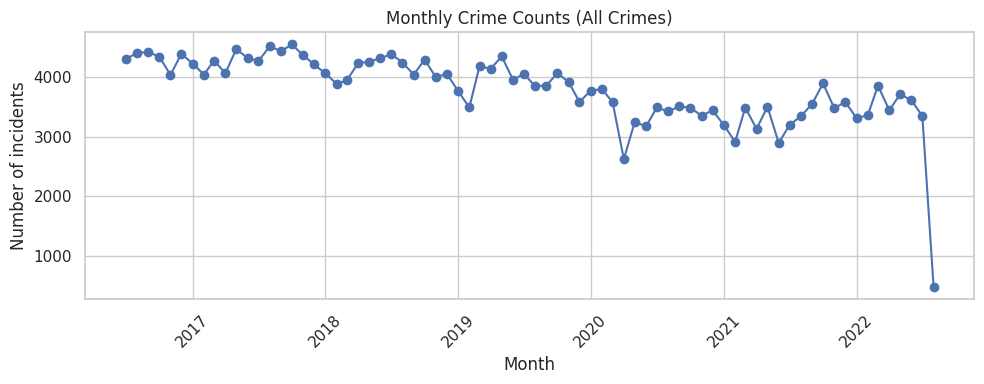

In [172]:
# Start from cleaned data
ts6_df = df_clean.copy()

# Keep rows with valid start datetime
ts6_df = ts6_df.dropna(subset=["start_dt"])

# Month start for grouping
ts6_df["month_start"] = ts6_df["start_dt"].dt.to_period("M").dt.to_timestamp()

monthly_counts_6 = (
    ts6_df
    .groupby("month_start")
    .size()
    .rename("count")
    .sort_index()
)

print("Time range:", monthly_counts_6.index.min(), "->", monthly_counts_6.index.max())
print("Number of months:", len(monthly_counts_6))

plt.figure(figsize=(10, 4))
plt.plot(monthly_counts_6.index, monthly_counts_6.values, marker="o")
plt.xlabel("Month")
plt.ylabel("Number of incidents")
plt.title("Monthly Crime Counts (All Crimes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Train / Test Split For Time Series (Last 12 Months As Test)

In [173]:
# Use last 12 months (adjust if different horizon is needed)
test_horizon = 12
if len(monthly_counts_6) <= test_horizon + 5:
    raise ValueError("Not enough history for chosen test horizon")

train_series = monthly_counts_6.iloc[:-test_horizon]
test_series = monthly_counts_6.iloc[-test_horizon:]

print("Train period:", train_series.index.min(), "->", train_series.index.max())
print("Test period :", test_series.index.min(), "->", test_series.index.max())
print("Train length:", len(train_series), "months")
print("Test length :", len(test_series), "months")

Train period: 2016-07-01 00:00:00 -> 2021-08-01 00:00:00
Test period : 2021-09-01 00:00:00 -> 2022-08-01 00:00:00
Train length: 62 months
Test length : 12 months


## Baseline Forecasts (Naive And Seasonal Naive)

Naive RMSE: 870.77
Seasonal naive RMSE: 886.07


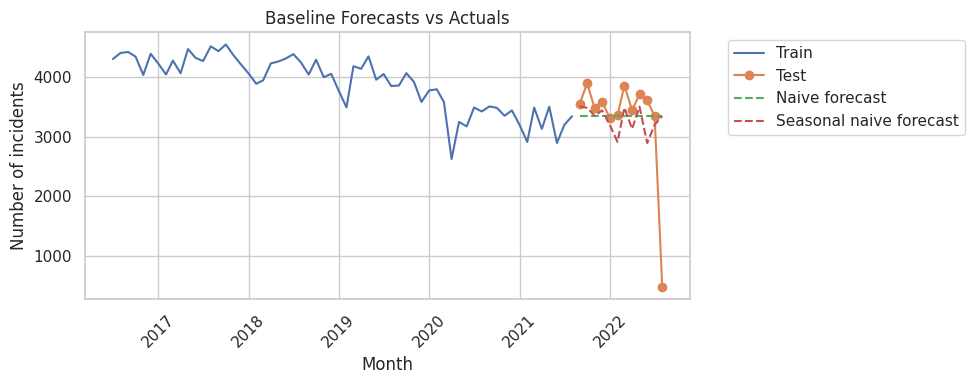

In [174]:
# Naive: forecast = last observed train value
naive_forecast = pd.Series(
    train_series.iloc[-1],
    index=test_series.index,
    name="naive"
)

# Seasonal naive: value from same month last year (if available)
season_length = 12
seasonal_forecast = []
for i, dt in enumerate(test_series.index):
    # index of same position one season back
    idx_in_full = monthly_counts_6.index.get_loc(dt)
    idx_past = idx_in_full - season_length
    if idx_past >= 0:
        seasonal_forecast.append(monthly_counts_6.iloc[idx_past])
    else:
        seasonal_forecast.append(train_series.iloc[-1])

seasonal_forecast = pd.Series(seasonal_forecast, index=test_series.index, name="seasonal_naive")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_naive = rmse(test_series, naive_forecast)
rmse_seasonal = rmse(test_series, seasonal_forecast)

print(f"Naive RMSE: {rmse_naive:,.2f}")
print(f"Seasonal naive RMSE: {rmse_seasonal:,.2f}")

plt.figure(figsize=(10, 4))
plt.plot(train_series.index, train_series.values, label="Train")
plt.plot(test_series.index, test_series.values, label="Test", marker="o")
plt.plot(test_series.index, naive_forecast.values, label="Naive forecast", linestyle="--")
plt.plot(test_series.index, seasonal_forecast.values, label="Seasonal naive forecast", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Number of incidents")
plt.title("Baseline Forecasts vs Actuals")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## SARIMA Model (Statsmodels) – Fit And Backtest

SARIMA RMSE: 906.72


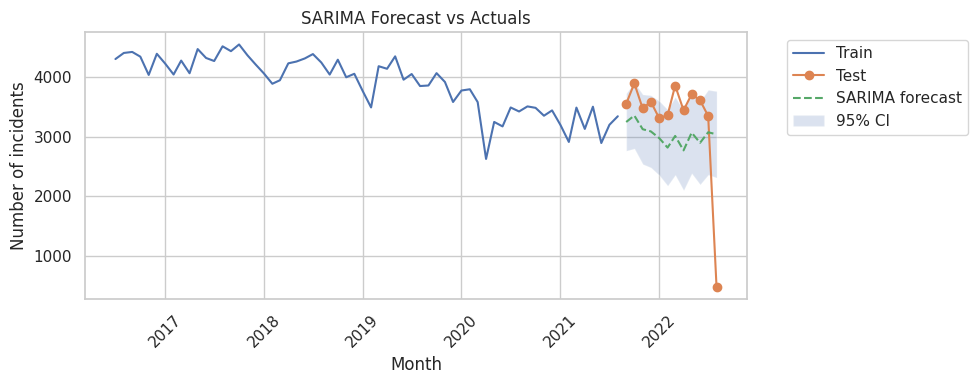

In [175]:
# Basic SARIMA configuration (you can tune these orders)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

sarima_model = SARIMAX(
    train_series,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarima_result = sarima_model.fit(disp=False)

# Forecast over the test period
sarima_forecast = sarima_result.get_forecast(steps=len(test_series))
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

rmse_sarima = np.sqrt(mean_squared_error(test_series, sarima_pred))
print(f"SARIMA RMSE: {rmse_sarima:,.2f}")

plt.figure(figsize=(10, 4))
plt.plot(train_series.index, train_series.values, label="Train")
plt.plot(test_series.index, test_series.values, label="Test", marker="o")
plt.plot(test_series.index, sarima_pred.values, label="SARIMA forecast", linestyle="--")

# Confidence intervals
plt.fill_between(
    test_series.index,
    sarima_ci["lower count"],
    sarima_ci["upper count"],
    alpha=0.2,
    label="95% CI",
)

plt.xlabel("Month")
plt.ylabel("Number of incidents")
plt.title("SARIMA Forecast vs Actuals")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Future Forecast (Next 12 Months, County-Wide)

              forecast     lower_95     upper_95
2022-09-01 -163.715721 -1130.005575   802.574133
2022-10-01  -68.423642 -1622.627437  1485.780154
2022-11-01 -279.490312 -2259.572956  1700.592332
2022-12-01 -279.799308 -2609.348022  2049.749407
2023-01-01 -439.630116 -3072.670388  2193.410155


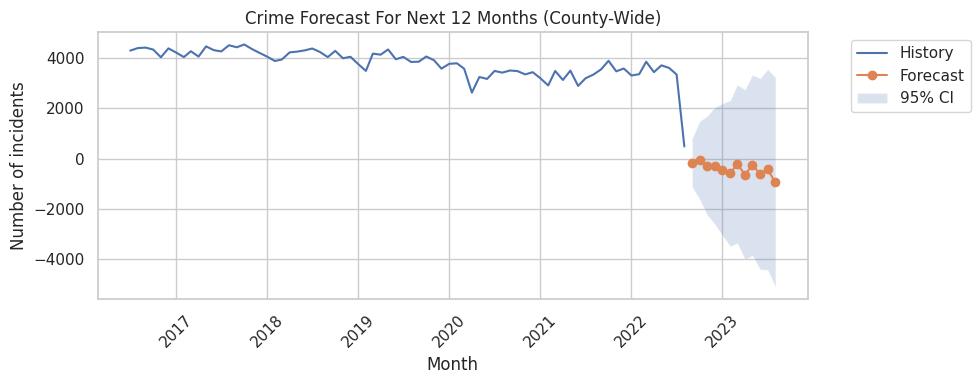

In [176]:
# Refit SARIMA on full series for future forecasts
sarima_full = SARIMAX(
    monthly_counts_6,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
)

sarima_full_result = sarima_full.fit(disp=False)

future_steps = 12
future_forecast = sarima_full_result.get_forecast(steps=future_steps)
future_pred = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

future_df = pd.DataFrame({
    "forecast": future_pred,
    "lower_95": future_ci["lower count"],
    "upper_95": future_ci["upper count"],
})

print(future_df.head())

plt.figure(figsize=(10, 4))
plt.plot(monthly_counts_6.index, monthly_counts_6.values, label="History")
plt.plot(future_pred.index, future_pred.values, label="Forecast", marker="o")
plt.fill_between(
    future_pred.index,
    future_ci["lower count"],
    future_ci["upper count"],
    alpha=0.2,
    label="95% CI",
)
plt.xlabel("Month")
plt.ylabel("Number of incidents")
plt.title("Crime Forecast For Next 12 Months (County-Wide)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Per-District Forecasts (Top 3 Districts By Volume, Naive + SARIMA)**bold text**

In [177]:
# Choose top districts
if "district" not in df_clean.columns:
    raise ValueError("Column 'district' is required for per-district forecasting")

dist_counts = (
    df_clean
    .dropna(subset=["district", "start_dt"])
    .groupby("district")
    .size()
    .sort_values(ascending=False)
)

top_k = 3
top_districts = dist_counts.head(top_k).index.tolist()
print("Top districts:", top_districts)

district_forecasts = {}

for dist in top_districts:
    # 6.6.2 Build monthly series per district
    sub = df_clean[(df_clean["district"] == dist) & df_clean["start_dt"].notna()].copy()
    sub["month_start"] = sub["start_dt"].dt.to_period("M").dt.to_timestamp()
    series = (
        sub
        .groupby("month_start")
        .size()
        .rename("count")
        .sort_index()
    )

    if len(series) <= test_horizon + 5:
        print(f"Skipping district {dist} (insufficient history)")
        continue

    train_sub = series.iloc[:-test_horizon]
    test_sub = series.iloc[-test_horizon:]

    # Naive baseline
    naive_sub = pd.Series(train_sub.iloc[-1], index=test_sub.index)

    # SARIMA model; reuse same orders as county-wide for simplicity
    model_sub = SARIMAX(
        train_sub,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)

    forecast_sub = model_sub.get_forecast(steps=len(test_sub))
    pred_sub = forecast_sub.predicted_mean

    rmse_naive_sub = np.sqrt(mean_squared_error(test_sub, naive_sub))
    rmse_sarima_sub = np.sqrt(mean_squared_error(test_sub, pred_sub))

    district_forecasts[dist] = {
        "series": series,
        "train": train_sub,
        "test": test_sub,
        "naive": naive_sub,
        "sarima_pred": pred_sub,
        "rmse_naive": rmse_naive_sub,
        "rmse_sarima": rmse_sarima_sub,
    }

    print(f"\nDistrict: {dist}")
    print(f"  Naive RMSE : {rmse_naive_sub:,.2f}")
    print(f"  SARIMA RMSE: {rmse_sarima_sub:,.2f}")

Top districts: ['SILVER SPRING', 'WHEATON', 'MONTGOMERY VILLAGE']

District: SILVER SPRING
  Naive RMSE : 177.88
  SARIMA RMSE: 198.80

District: WHEATON
  Naive RMSE : 153.41
  SARIMA RMSE: 156.00

District: MONTGOMERY VILLAGE
  Naive RMSE : 155.20
  SARIMA RMSE: 174.97


## Visualise Per-District Forecasts (Top 3)

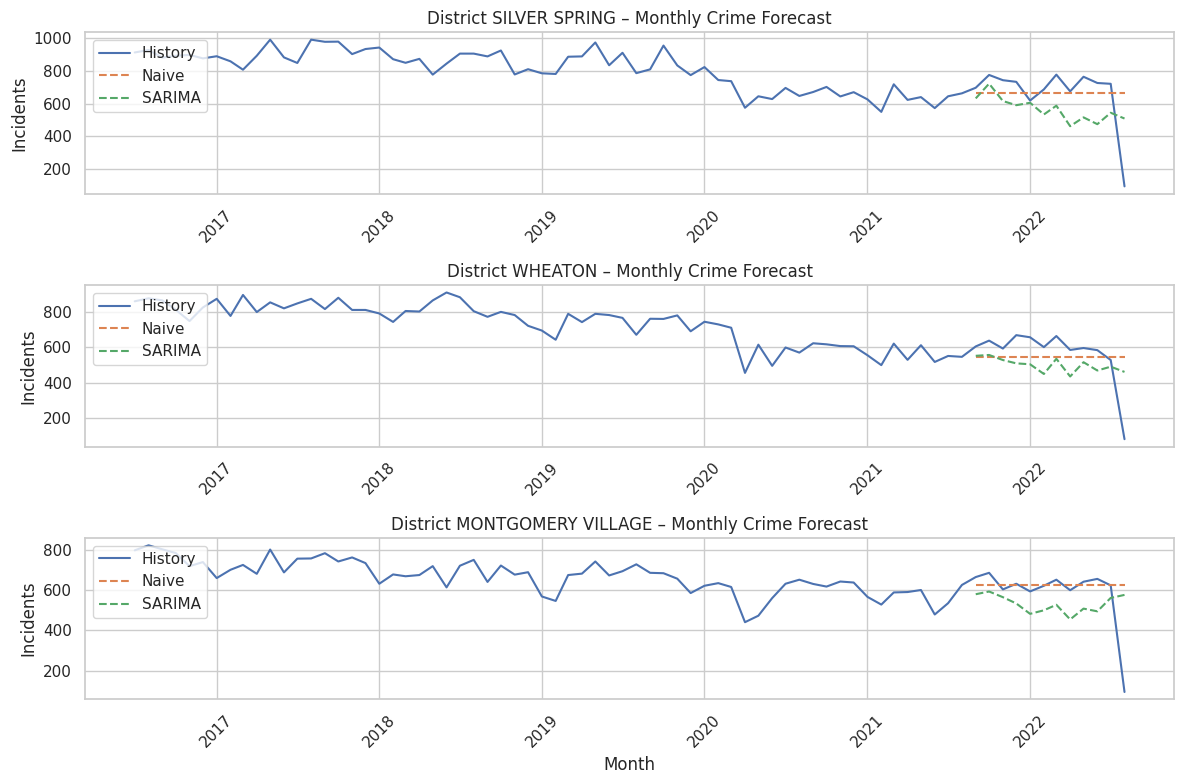

In [178]:
plt.figure(figsize=(12, 8))

for i, (dist, info) in enumerate(district_forecasts.items(), start=1):
    series = info["series"]
    train_sub = info["train"]
    test_sub = info["test"]
    naive_sub = info["naive"]
    sarima_pred_sub = info["sarima_pred"]

    plt.subplot(len(district_forecasts), 1, i)
    plt.plot(series.index, series.values, label="History")
    plt.plot(test_sub.index, naive_sub.values, label="Naive", linestyle="--")
    plt.plot(test_sub.index, sarima_pred_sub.values, label="SARIMA", linestyle="--")
    plt.title(f"District {dist} – Monthly Crime Forecast")
    plt.ylabel("Incidents")
    if i == len(district_forecasts):
        plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

## Markdown Explanation

In [179]:
markdown_text = """
### Explanation of Idea 6 forecasting outputs

1. **Overall monthly crime trend**
   The first plot summarises monthly crime counts for the entire county from July 2016 to August 2022, a total of 74 months. For most of the period the series fluctuates between roughly 3,000 and 4,500 incidents per month. There is a noticeable drop around early 2020 that likely reflects the impact of pandemic restrictions on mobility and reporting. After this shock the series stabilises at a slightly lower level, with some recovery during 2021 and 2022. The very last point is far lower than the rest of the series because the final month is only partially observed in the dataset. This incomplete month is important because it makes forecasting more difficult and can influence model behaviour.

2. **Train and test split**
   To evaluate forecasting models fairly, the time series is divided into a training set and a hold out test set. The first 62 months, from July 2016 to August 2021, are used for model fitting. The last 12 months, from September 2021 to August 2022, are reserved for testing. This design mirrors a realistic operational setting: the model is trained on past data then asked to predict future values that were not seen during training.

3. **Baseline forecasts**
   Two simple benchmark methods are used as baselines. The naive forecast assumes that all future months will equal the final value from the training period. The seasonal naive method uses the value from the same month one year earlier, which embeds a simple yearly seasonality. Both baselines produce root mean squared error (RMSE) values around 870 to 890 incidents on the test period. The comparison plot shows that these baseline forecasts are reasonably close to the observed counts but do not match the month to month fluctuations, especially around local peaks and troughs.

4. **SARIMA model performance**
   A seasonal ARIMA model is then fitted to the training series with a yearly seasonal component. On the test period its RMSE is around 907, slightly worse than both naive baselines. Visually the SARIMA forecast produces a smooth trajectory that underestimates the peaks and does not react to the sudden decline in the final incomplete month. The confidence interval widens over the forecast horizon, reflecting uncertainty, yet the central forecast still misses the more abrupt changes. This result highlights an important modelling lesson: a more complex time series model does not automatically outperform simple baselines when the data contain structural breaks and irregular last observations.

5. **Future county wide forecast**
   After evaluation, the SARIMA model is refitted on the full historical series and used to forecast the next twelve months. The forecast table and plot show that the central predictions drift slightly downward and even become negative in several months, with wide confidence intervals that span both positive and negative values. Negative incident counts are not meaningful in practice, so this behaviour indicates that the model is extrapolating the recent sharp decline at the end of the series rather than learning a stable level. In a real deployment one would clip predictions at zero and likely retrain the model after removing or adjusting the incomplete final month.

6. **Per district forecasting for top districts**
   The analysis is repeated for the three districts with the highest historical crime volumes: Silver Spring, Wheaton, and Montgomery Village. For each district a separate monthly series is built and split into training and test segments. Naive and SARIMA models are fitted and evaluated. The RMSE values show that the naive method slightly outperforms or matches SARIMA across all three districts. The forecast plots demonstrate why: the naive lines sit close to the recent history, while the SARIMA forecasts tend to underestimate the counts as they smooth over sudden drops. This district level comparison underlines how critical it is to benchmark sophisticated models against simple baselines and to check performance in different sub regions rather than only at the aggregate level.

7. **Interpretation for the project**
   Taken together, these results show that crime forecasting in this dataset is constrained by structural changes and incomplete recent observations. Simple naive methods already provide strong baselines, and the SARIMA model, although statistically more advanced, offers only marginal or even worse performance without careful tuning. From a methodological perspective this part of the project demonstrates the full forecasting workflow: constructing a time series, designing an out of sample evaluation strategy, implementing baselines and SARIMA, computing error metrics, visualising predictions, and critically reflecting on when a complex model is justified.
"""

display(Markdown(markdown_text))


### Explanation of Idea 6 forecasting outputs  

1. **Overall monthly crime trend**  
   The first plot summarises monthly crime counts for the entire county from July 2016 to August 2022, a total of 74 months. For most of the period the series fluctuates between roughly 3,000 and 4,500 incidents per month. There is a noticeable drop around early 2020 that likely reflects the impact of pandemic restrictions on mobility and reporting. After this shock the series stabilises at a slightly lower level, with some recovery during 2021 and 2022. The very last point is far lower than the rest of the series because the final month is only partially observed in the dataset. This incomplete month is important because it makes forecasting more difficult and can influence model behaviour.

2. **Train and test split**  
   To evaluate forecasting models fairly, the time series is divided into a training set and a hold out test set. The first 62 months, from July 2016 to August 2021, are used for model fitting. The last 12 months, from September 2021 to August 2022, are reserved for testing. This design mirrors a realistic operational setting: the model is trained on past data then asked to predict future values that were not seen during training.

3. **Baseline forecasts**  
   Two simple benchmark methods are used as baselines. The naive forecast assumes that all future months will equal the final value from the training period. The seasonal naive method uses the value from the same month one year earlier, which embeds a simple yearly seasonality. Both baselines produce root mean squared error (RMSE) values around 870 to 890 incidents on the test period. The comparison plot shows that these baseline forecasts are reasonably close to the observed counts but do not match the month to month fluctuations, especially around local peaks and troughs.

4. **SARIMA model performance**  
   A seasonal ARIMA model is then fitted to the training series with a yearly seasonal component. On the test period its RMSE is around 907, slightly worse than both naive baselines. Visually the SARIMA forecast produces a smooth trajectory that underestimates the peaks and does not react to the sudden decline in the final incomplete month. The confidence interval widens over the forecast horizon, reflecting uncertainty, yet the central forecast still misses the more abrupt changes. This result highlights an important modelling lesson: a more complex time series model does not automatically outperform simple baselines when the data contain structural breaks and irregular last observations.

5. **Future county wide forecast**  
   After evaluation, the SARIMA model is refitted on the full historical series and used to forecast the next twelve months. The forecast table and plot show that the central predictions drift slightly downward and even become negative in several months, with wide confidence intervals that span both positive and negative values. Negative incident counts are not meaningful in practice, so this behaviour indicates that the model is extrapolating the recent sharp decline at the end of the series rather than learning a stable level. In a real deployment one would clip predictions at zero and likely retrain the model after removing or adjusting the incomplete final month.

6. **Per district forecasting for top districts**  
   The analysis is repeated for the three districts with the highest historical crime volumes: Silver Spring, Wheaton, and Montgomery Village. For each district a separate monthly series is built and split into training and test segments. Naive and SARIMA models are fitted and evaluated. The RMSE values show that the naive method slightly outperforms or matches SARIMA across all three districts. The forecast plots demonstrate why: the naive lines sit close to the recent history, while the SARIMA forecasts tend to underestimate the counts as they smooth over sudden drops. This district level comparison underlines how critical it is to benchmark sophisticated models against simple baselines and to check performance in different sub regions rather than only at the aggregate level.

7. **Interpretation for the project**  
   Taken together, these results show that crime forecasting in this dataset is constrained by structural changes and incomplete recent observations. Simple naive methods already provide strong baselines, and the SARIMA model, although statistically more advanced, offers only marginal or even worse performance without careful tuning. From a methodological perspective this part of the project demonstrates the full forecasting workflow: constructing a time series, designing an out of sample evaluation strategy, implementing baselines and SARIMA, computing error metrics, visualising predictions, and critically reflecting on when a complex model is justified.


# Idea 7: Crime Analytics Dashboard With Plotly Dash

## Data Preparation

In [197]:
# Use cleaned data
dash_df = df_clean.copy()

# Ensure start_dt is datetime
dash_df["start_dt"] = pd.to_datetime(dash_df["start_dt"], errors="coerce")
dash_df = dash_df.dropna(subset=["start_dt"])

# Create helper time columns
dash_df["date"] = dash_df["start_dt"].dt.date
dash_df["month_start"] = dash_df["start_dt"].dt.to_period("M").dt.to_timestamp()

# Basic ranges for filters
min_date = dash_df["date"].min()
max_date = dash_df["date"].max()

crime_types = sorted(dash_df["crime_type"].dropna().unique().tolist())
districts = sorted(dash_df["district"].dropna().unique().tolist())

print("Date range in data:", min_date, "to", max_date)
print("Number of crime types:", len(crime_types))
print("Number of districts:", len(districts))

Date range in data: 2016-07-01 to 2022-08-07
Number of crime types: 5
Number of districts: 10


## Build Dash App Layout

In [198]:
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

def kpi_card(id_value, title):
    """Small helper to create KPI cards."""
    return dbc.Card(
        [
            html.H6(title, className="card-title"),
            html.H3(id=id_value, className="card-text"),
        ],
        body=True,
        className="m-1",
    )

app.layout = dbc.Container(
    [
        html.H2("Montgomery County Crime Analytics Dashboard"),
        html.P("Interactive dashboard built from the cleaned incident dataset."),

        # Filters
        dbc.Row(
            [
                dbc.Col(
                    [
                        html.Label("Date range"),
                        dcc.DatePickerRange(
                            id="filter-date-range",
                            min_date_allowed=min_date,
                            max_date_allowed=max_date,
                            start_date=min_date,
                            end_date=max_date,
                            display_format="YYYY-MM-DD",
                        ),
                    ],
                    md=4,
                ),
                dbc.Col(
                    [
                        html.Label("Crime type"),
                        dcc.Dropdown(
                            id="filter-crime-type",
                            options=[{"label": c, "value": c} for c in crime_types],
                            value=[],
                            multi=True,
                            placeholder="All crime types",
                        ),
                    ],
                    md=4,
                ),
                dbc.Col(
                    [
                        html.Label("District"),
                        dcc.Dropdown(
                            id="filter-district",
                            options=[{"label": d, "value": d} for d in districts],
                            value=[],
                            multi=True,
                            placeholder="All districts",
                        ),
                    ],
                    md=4,
                ),
            ],
            className="mt-3",
        ),

        # KPIs
        dbc.Row(
            [
                dbc.Col(kpi_card("kpi-total", "Total incidents"), md=4),
                dbc.Col(kpi_card("kpi-severe-share", "Severe incidents share"), md=4),
                dbc.Col(kpi_card("kpi-monthly-avg", "Average incidents per month"), md=4),
            ],
            className="mt-3",
        ),

        # Time series and district summary
        dbc.Row(
            [
                dbc.Col(
                    dcc.Graph(id="ts-monthly-crime"),
                    md=6,
                ),
                dbc.Col(
                    dcc.Graph(id="bar-district-crime"),
                    md=6,
                ),
            ],
            className="mt-3",
        ),

        # Map
        dbc.Row(
            [
                dbc.Col(
                    dcc.Graph(id="map-crime"),
                    md=12,
                )
            ],
            className="mt-3",
        ),
    ],
    fluid=True,
)

## Callbacks To Update KPIs And Charts

In [199]:
def filter_data(start_date, end_date, crime_type_values, district_values):
    """Return filtered dataframe based on current selections."""
    df = dash_df.copy()

    if start_date is not None:
        df = df[df["date"] >= pd.to_datetime(start_date).date()]
    if end_date is not None:
        df = df[df["date"] <= pd.to_datetime(end_date).date()]

    if crime_type_values:
        df = df[df["crime_type"].isin(crime_type_values)]
    if district_values:
        df = df[df["district"].isin(district_values)]

    return df


@app.callback(
    [
        Output("kpi-total", "children"),
        Output("kpi-severe-share", "children"),
        Output("kpi-monthly-avg", "children"),
        Output("ts-monthly-crime", "figure"),
        Output("bar-district-crime", "figure"),
        Output("map-crime", "figure"),
    ],
    [
        Input("filter-date-range", "start_date"),
        Input("filter-date-range", "end_date"),
        Input("filter-crime-type", "value"),
        Input("filter-district", "value"),
    ],
)
def update_dashboard(start_date, end_date, crime_type_values, district_values):
    df = filter_data(start_date, end_date, crime_type_values, district_values)

    if df.empty:
        empty_fig = px.scatter(title="No data for selected filters")
        return "0", "N/A", "0", empty_fig, empty_fig, empty_fig

    # KPIs
    total_incidents = len(df)

    if "severe" in df.columns:
        severe_share = df["severe"].mean() * 100
        severe_text = f"{severe_share:.1f}%"
    else:
        severe_text = "N/A"

    monthly_counts = (
        df.groupby("month_start")
          .size()
          .rename("count")
          .reset_index()
    )
    monthly_avg = monthly_counts["count"].mean()

    # Time series figure
    fig_ts = px.line(
        monthly_counts,
        x="month_start",
        y="count",
        markers=True,
        labels={"month_start": "Month", "count": "Number of incidents"},
        title="Monthly crime trend",
    )

    # District bar chart (sorted by descending incident count)
    df_dist = (
        df["district"]
        .fillna("Unknown")
        .value_counts()
        .reset_index()
    )
    # Ensure clean column names: ["district", "incident_count"]
    df_dist.columns = ["district", "incident_count"]

    fig_dist = px.bar(
        df_dist,
        x="district",
        y="incident_count",
        title="Incidents by district",
        labels={"district": "District", "incident_count": "Number of incidents"},
    )
    fig_dist.update_layout(xaxis={"categoryorder": "total descending"})

    # Map figure with richer hover tooltips
    if {"lat", "lon"}.issubset(df.columns):
        # Decide which extra columns to show on hover
        hover_cols = [
            col for col in ["district", "crime_type", "place", "start_dt", "victims", "severe"]
            if col in df.columns
        ]

        # Sample up to 10k points for performance
        df_sample = df.sample(min(len(df), 10000), random_state=42)

        fig_map = px.scatter_mapbox(
            df_sample,
            lat="lat",
            lon="lon",
            color="crime_type",
            hover_name="crime_type" if "crime_type" in df_sample.columns else None,
            hover_data=hover_cols,
            zoom=9,
            height=500,
            title="Crime locations (sample up to 10,000 points)",
            color_discrete_sequence=px.colors.qualitative.Set1,
        )

        fig_map.update_traces(marker=dict(size=5, opacity=0.7))

        fig_map.update_layout(
            mapbox_style="open-street-map",
            margin={"r": 0, "t": 40, "l": 0, "b": 0},
            legend_title_text="Crime type",
        )
    else:
        fig_map = px.scatter(title="No latitude and longitude available")

    return (
        f"{total_incidents:,}",
        severe_text,
        f"{monthly_avg:,.1f}",
        fig_ts,
        fig_dist,
        fig_map,
    )

## Run The Dash App

In [200]:
if __name__ == "__main__":
    app.run_server(debug=True)

<IPython.core.display.Javascript object>